In [1]:
# Title: Contact models for atomic force microscopy
# Author: J. P. S. Ferreira
# Date: 2023-01-17
# Description: This notebook is a draft for a work on contact models for atomic force microscopy. It is a work in progress.
# Literature: 
# (1) https://www.sciencedirect.com/science/article/pii/S0968432822000245 
# (2) https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3010-3
# License: MIT

In [2]:
# Math and Dataframes
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.ticker import PercentFormatter

# Machine Learning 
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, KFold
import torch
from torch import nn
from torchinfo import summary
# from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter
# import verstack
# from verstack.stratified_continuous_split import scsplit

# Others
from datetime import datetime
import os
from pathlib import Path
import csv
import pickle



In [3]:
# Ensure we're working in the directory of this file
os.chdir('c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese\\contact-surface')

In [4]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

# update to latex fonts
plt.rcParams.update(tex_fonts)

## Hertz and JKR functions

In [5]:
def hertz(i, E, nu, r):
    """Hertz model for indentation.
    
    approximation for parabolic indenter.
    Parameters
    ----------
    i : float
        Indentation depth.
    E : float
        Young's modulus.
    nu : float
        Poisson's ratio.
    R : float
        Radius of the indenter/probing tip.
        
    Returns
    -------
    float
        Contact force.
    """
    # 'a' and 'factor' calculated based on ref (2)
    # search for other formulas to obtain these parameters
    a = i/r
    factor = 1 - 0.1 * a - (1/840) * a**2 + (11/15120) * a**3 + (1357/6652800) * a**4
    force = 4/3 * E / (1 - nu**2) * np.sqrt(r)*i**1.5 * factor
    # make nan values zero
    force[np.isnan(force)] = 0
    return force*10**-6

# Johnson-Kendall-Roberts model for indentation
# (3) https://lizidelcidphd.com/2017/07/07/the-simplified-johnson-kendall-roberts-model/
def jkr(i, E, nu, gamma, r):
    """Johnson-Kendall-Roberts model for indentation.
    
    Parameters
    ----------
    i : float
        Indentation depth.
    E : float
        Young's modulus.
    nu : float
        Poisson's ratio.
    gamma : float
        Surface energy.
    R : float
        Radius of the indenter.
        
    Returns
    -------
    float
        Contact force.
    """
    E = E * 10**3 # kPa to Pa
    i = i * 10**-9 # nm to m
    r = r * 10**-9 # nm to m
    gamma = gamma * 10**-6 # microJ/m^2 to J/m^2
    E_eff = E / (1 - nu**2)
    K = 4/3 * E_eff
    Ua = np.sqrt(6*np.pi*gamma)
    # JKR force formula in (3)
    force = K * r **0.5 * i**1.5 - Ua * K**0.5 * r**0.75 * i**0.75
    # make nan values zero
    force[np.isnan(force)] = 0
    # return force*10**-6
    return force*10**9
    '''E_eff = E / (1 - nu**2)
    K = 4/3 * E_eff
    Ua = np.sqrt(6*np.pi*gamma)
    # JKR force formula in (3)
    force =  10**-6 * K * r **0.5 * i**1.5 - Ua * K**0.5 * r**0.75 * i**0.75 * 10**(-4.5)
    # make nan values zero
    force[np.isnan(force)] = 0
    return force'''


## Parameter definition

In [6]:
# resolution of the map
res = 200
# random values
size = res * res
# size = 100000
# Seed (if needed)
np.random.seed(42)

# Young's modulus [kPa] - random values following a normal distribution
    #loc: mean/center of distribution
    #scale: std
# Normal distribution: 
'''E = abs(np.random.normal(loc=2.5, scale=1.8, size=size))
# Define a minimum value for a normal distribution, by multiplying lower values by a factor
while np.any(E < 0.2):
    E = np.where(E < 0.2, E*10, E)'''




# Uniform distribution:
# Uniform distribution with random seed
# np.random.seed(42)
# E = abs(np.random.uniform(low=0.2, high=10., size=size))

# Triangular distrbution
E = np.random.triangular(left=0.2, mode=1.8, right=10, size=size)

#Beta distribution:
'''a = 1.5
b = 4.5
E = np.random.beta(a, b, size=size)
E *= 10'''

# Poisson's ratio 
nu = 0.5

# surface energy
# gamma = abs(np.random.normal(loc=0.0001, scale=0.000003, size=size)) f (0,40)
# gamma = abs(np.random.normal(loc=2, scale=0.28, size=size))
gamma = abs(np.random.uniform(low=1., high=3., size=size))
# gamma = 0.1
# radius of the indenter
r = 1980.0 # (nm)


In [7]:
# count E lower than 5.93
print(np.count_nonzero(E < 5.93))

31096


(array([3963., 3995., 4012., 3958., 4045., 3967., 4031., 4066., 4093.,
        3870.]),
 array([1.00001686, 1.20000961, 1.40000235, 1.59999509, 1.79998784,
        1.99998058, 2.19997332, 2.39996607, 2.59995881, 2.79995155,
        2.99994429]),
 <BarContainer object of 10 artists>)

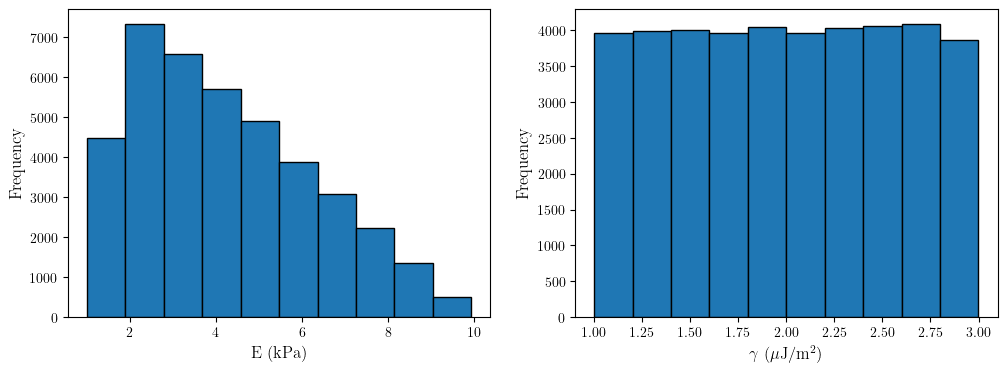

In [8]:
# no contact approach. less points
#linspace(p1, p2, n_pts)
no_contact = np.linspace(-800, 0, 3)

'''DISPLACEMENT VECTORS'''
xmin, xmax, npts = 0, 150, 50

'''Uniformly distributed disp. vectors'''
# indentation depth. more points
contact = np.linspace(xmin, xmax, npts+1)
# approach and withdraw
approach = np.concatenate([no_contact[:-1], contact])
withdraw = np.flip(approach)
ramp = np.concatenate([approach, withdraw])

'''Randomly distributed disp. vectors'''
# Seed (if needed)
np.random.seed(42)

rnd_contact_list = [contact]
for _ in range(size-1):
    aux = np.random.random(npts+1).cumsum()
    aux = (aux-aux.min()) / aux.ptp()     #... .ptp(): peak to peak, i.e., xmax-xmin
    aux = (xmax-xmin)*aux + xmin
    rnd_contact_list.append(aux)
rnd_contact = np.array(rnd_contact_list)
rnd_approach = np.concatenate([np.repeat([no_contact[:-1]], size, axis=0), rnd_contact], axis=1)
rnd_withdraw = np.flip(rnd_approach, axis=1)

# define ramp time
half_cycle = 2 
t_approach = half_cycle*((approach - approach.min(axis=0)) / (approach.max(axis=0) - approach.min(axis=0)))
t_withdraw = half_cycle*((withdraw - withdraw.max(axis=0)) / (withdraw.min(axis=0) - withdraw.max(axis=0)))+max(t_approach)
t = np.concatenate([t_approach, t_withdraw])
# fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,4))
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(12,4))
# ax1.set_xlabel('Time (s)')
# ax1.set_ylabel('Displacement')
# ax1.plot(t, ramp)
ax2.set_xlabel('E (kPa)')
ax2.set_ylabel('Frequency')

ax2.hist(E, 10, ec='black')
ax3.set_xlabel('$\gamma$ ($\mu$J/m$^2$)')
ax3.set_ylabel('Frequency')
ax3.hist(gamma, 10, ec='black')

# fig.savefig('histogram.pdf')

## Initial df

In [9]:
# construct dataframe
df = pd.DataFrame()
# 'E' and 'gamma' arrays to list:
df['E'] = E.tolist()
df['gamma'] = gamma.tolist()
# assigns the displacement array for each 'E' (num of E values = len(df) = size)
df['approach'] = [rnd_approach[app] for app in range(len(df))]
df['withdraw'] = [rnd_withdraw[wd] for wd in range(len(df))]
# '..._interp' columns have the sole purpose of allowing the sns errorbar plot 
df['approach_interp'] = [approach for _ in range(len(df))]
df['withdraw_interp'] = [withdraw for _ in range(len(df))]
# applies hertz and jkr models to each row (axis= 0(col) or 1(row))
    # x will take the values of each row 
df['f_hertz'] = df.apply(lambda x: hertz(x.approach, x.E, nu, r), axis=1)
df['f_jkr'] = df.apply(lambda x: jkr(x.withdraw, x.E, nu, x.gamma, r), axis=1)
df['f_hertz_interp'] = df.apply(lambda x: np.interp(x.approach_interp, x.approach, x.f_hertz), axis=1)
df['f_jkr_interp'] = df.apply(lambda x: np.interp(-x.withdraw_interp, -x.withdraw, x.f_jkr), axis=1)
df['approach'][8]

C:\Users\luisr\AppData\Local\Temp\ipykernel_22964\2396209638.py:25: RuntimeWarning: invalid value encountered in power
  force = 4/3 * E / (1 - nu**2) * np.sqrt(r)*i**1.5 * factor
C:\Users\luisr\AppData\Local\Temp\ipykernel_22964\2396209638.py:61: RuntimeWarning: invalid value encountered in power
  force = K * r **0.5 * i**1.5 - Ua * K**0.5 * r**0.75 * i**0.75


array([-800.        , -400.        ,    0.        ,    5.28078726,
          8.51292825,   10.69307807,   14.30609548,   16.87986509,
         19.94431256,   25.23203375,   27.40057268,   32.79908324,
         37.88396981,   38.98362741,   39.37319398,   39.93921192,
         40.0415545 ,   40.57199179,   44.40808779,   44.80791763,
         46.59943886,   51.34466676,   51.4753732 ,   56.04982166,
         57.63285424,   58.296525  ,   62.20973751,   65.74218437,
         70.6704911 ,   74.79900519,   79.31174225,   80.89578466,
         81.89237086,   86.10818592,   90.6397596 ,   96.20291498,
         98.52037519,  100.60980848,  104.97051874,  106.88463607,
        112.11221885,  116.93347956,  119.34291726,  123.56017192,
        127.79804922,  128.37724268,  133.44641582,  136.28415723,
        140.92594162,  142.72349479,  147.75318586,  149.93913051,
        150.        ])

## Initial df - plots

In [10]:
'''for ii in range(len(df)):
    if (df['E'][ii] > 7.5 or df['E'][ii] < 2) and (df['gamma'][ii] < 1.2 or df['gamma'][ii] > 2.6):
        # ii = 0
        plt.figure()
        plt.plot(df['approach'][ii], df['f_hertz'][ii], color='blue', alpha=0.9, label='Approach')
        plt.plot(df['withdraw'][ii], df['f_jkr'][ii], color='orange', alpha=0.9, label='Withdraw')
        #add labels
        plt.legend(fontsize=14)
        plt.xlabel('Indentation (nm)', fontsize=15)
        plt.ylabel('Force (nN)', fontsize=15)
        # Insert box with parameters, below the legend
        textstr = '\n'.join((
            r'$E=%.2f$ kPa' % (df['E'][ii], ),
            r'$\gamma=%.2f$ $\mu$J/m$^2$' % (df['gamma'][ii], )))
        props = dict(boxstyle='round', facecolor='white', alpha=0.2)
        plt.text(0.7, 0.78, textstr, transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=props)
        plt.ylim(-0.05, 1.21)
        # invert x axis
        # plt.axis() returns (xmin, xmax, ymin, ymax)
        ax = plt.axis()
        plt.axis((ax[1],-400,ax[2],ax[3]))
        # save figure
        plt.savefig('Curvas sinteticas/fig'+str(ii)+'.pdf', bbox_inches='tight')'''


"for ii in range(len(df)):\n    if (df['E'][ii] > 7.5 or df['E'][ii] < 2) and (df['gamma'][ii] < 1.2 or df['gamma'][ii] > 2.6):\n        # ii = 0\n        plt.figure()\n        plt.plot(df['approach'][ii], df['f_hertz'][ii], color='blue', alpha=0.9, label='Approach')\n        plt.plot(df['withdraw'][ii], df['f_jkr'][ii], color='orange', alpha=0.9, label='Withdraw')\n        #add labels\n        plt.legend(fontsize=14)\n        plt.xlabel('Indentation (nm)', fontsize=15)\n        plt.ylabel('Force (nN)', fontsize=15)\n        # Insert box with parameters, below the legend\n        textstr = '\n'.join((\n            r'$E=%.2f$ kPa' % (df['E'][ii], ),\n            r'$\\gamma=%.2f$ $\\mu$J/m$^2$' % (df['gamma'][ii], )))\n        props = dict(boxstyle='round', facecolor='white', alpha=0.2)\n        plt.text(0.7, 0.78, textstr, transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', bbox=props)\n        plt.ylim(-0.05, 1.21)\n        # invert x axis\n        # plt.axis() returns

(197.5, -847.5, -0.1009646787218498, 1.5044856954564338)

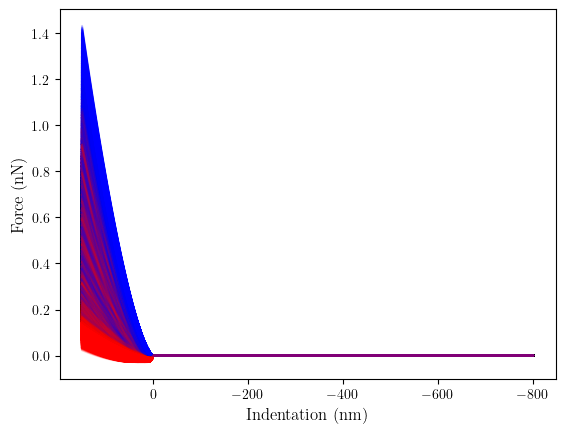

In [11]:
# plot all entries naively
# i: row index; row: data of each row in series format
for i, row in df.iterrows():
    #alpha: transparency
    plt.plot(row['approach'], row['f_hertz'], color='blue', alpha=0.1)
    plt.plot(row['withdraw'], row['f_jkr'], color='red', alpha=0.1)
    # plt.plot(row['withdraw'][0], row['f_jkr'][0], color='red', alpha=0.1)
#add labels
plt.xlabel('Indentation (nm)')
plt.ylabel('Force (nN)')
# invert x axis
# plt.axis() returns (xmin, xmax, ymin, ymax)
ax = plt.axis()
plt.axis((ax[1],ax[0],ax[2],ax[3]))

In [12]:
# Approach and retraction curves (mean and std)

# Load df_final.pkl
'''df_final_exp = pd.read_pickle('df_final.pkl')
df_final_exp['approach_interp'] = [approach for _ in range(len(df_final_exp))]
df_final_exp['f_hertz_interp'] = df_final_exp.apply(lambda x: np.interp(x.approach_interp, x.ind, x.force), axis=1)
df_final_exp_interp = df_final_exp[['approach_interp', 'f_hertz_interp']]
df_final_exp_interp = df_final_exp_interp.apply(pd.Series.explode).reset_index(drop=True)
# plot all entries with seaborn
    # set_index: sets 'E' as the index (so the right value of E is assigned to the correct rows after the explode)
    # Series.explode: 'explodes' the arrays (disp and force) into different rows (scalars in each cell instead of arrays)
    # reset_index: because E is no longer needed as an index
# Drop columns in df with E > 5
df = df[df['E'] < 4]'''

'''df2 = df.set_index(['E', 'gamma']).apply(pd.Series.explode).reset_index()
ax = sns.lineplot(data=df2, x='approach_interp', y='f_hertz_interp', palette='Set1', errorbar='sd', color='blue', label='Approach')
ax = sns.lineplot(data=df2, x='withdraw_interp', y='f_jkr_interp',  palette='Set2', errorbar='sd', color = 'red', label='Withdraw', err_style="band", ls='--')
# ax = sns.lineplot(data=df_final_exp_interp, x='approach_interp', y='f_hertz_interp',  palette='Set2', errorbar='sd', color = 'orange', label='Experimental')
# Increase legend font size
ax.legend(fontsize=16)
ax.set_xlabel('Indentation (nm)', fontsize=16)
ax.set_ylabel('Force (nN)', fontsize=16)
ax.set_xlim((180,-60))
# save figure
plt.savefig('realistic.pdf', bbox_inches='tight')'''

'df2 = df.set_index([\'E\', \'gamma\']).apply(pd.Series.explode).reset_index()\nax = sns.lineplot(data=df2, x=\'approach_interp\', y=\'f_hertz_interp\', palette=\'Set1\', errorbar=\'sd\', color=\'blue\', label=\'Approach\')\nax = sns.lineplot(data=df2, x=\'withdraw_interp\', y=\'f_jkr_interp\',  palette=\'Set2\', errorbar=\'sd\', color = \'red\', label=\'Withdraw\', err_style="band", ls=\'--\')\n# ax = sns.lineplot(data=df_final_exp_interp, x=\'approach_interp\', y=\'f_hertz_interp\',  palette=\'Set2\', errorbar=\'sd\', color = \'orange\', label=\'Experimental\')\n# Increase legend font size\nax.legend(fontsize=16)\nax.set_xlabel(\'Indentation (nm)\', fontsize=16)\nax.set_ylabel(\'Force (nN)\', fontsize=16)\nax.set_xlim((180,-60))\n# save figure\nplt.savefig(\'realistic.pdf\', bbox_inches=\'tight\')'

## Initial df - Mapping E

<AxesSubplot: >

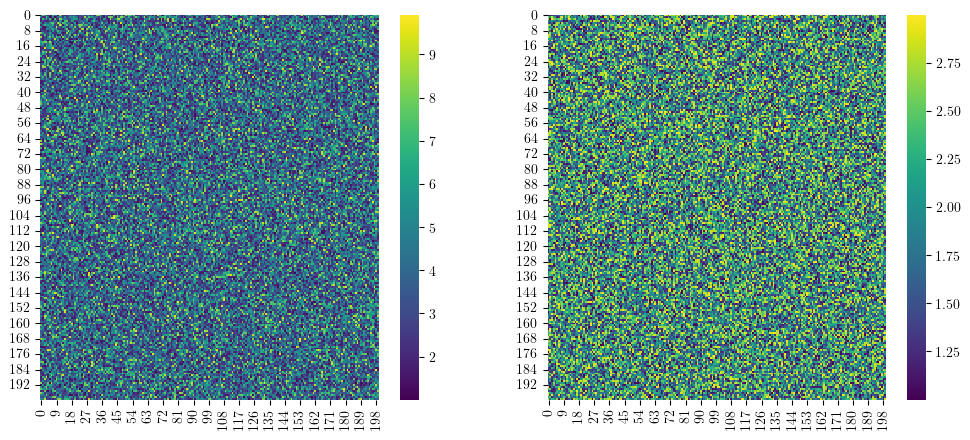

In [13]:
# map random values to a 2D array
#transforms E from array to matrix
E_map = np.reshape(E, (res, res))
gamma_map = np.reshape(gamma, (res, res))
# Young's modulus and surface energy random maps
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(E_map, cmap='viridis', ax=axes[0])
sns.heatmap(gamma_map, cmap='viridis', ax=axes[1])
#NOTE: examples at https://seaborn.pydata.org/examples/index.html

<AxesSubplot: >

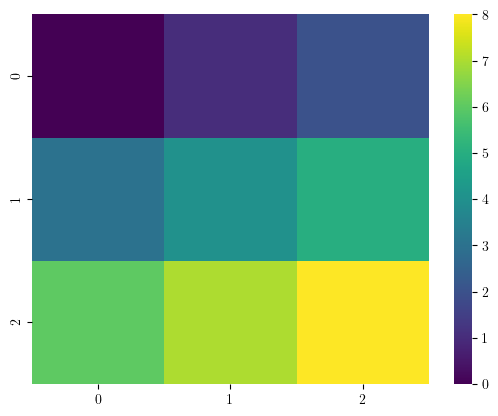

In [14]:
#check reshape rule.
# create sequential integers array of size 9
v = np.arange(0, 9, 1, dtype=int)
# reshape to 3x3
vmap = np.reshape(v, (3, 3))
# print array
sns.heatmap(vmap, cmap='viridis')
#NOTE: reshape rule is row-major, i.e. the first index is the row index. The second index is the column index.

# **HERTZ**

In [15]:
#dataframe with contact-only data
#df_hc: hertz contact
df_hc = pd.DataFrame()
df_hc['approach_contact'] = df['approach'].apply(lambda x: x[x>0]) # Para considerar o 0: x>=0
df_hc['f_hertz_contact'] = df['f_hertz'].apply(lambda x: x[len(no_contact):]) # len(no_contact)-1
df_hc['E_hertz'] = df['E']
#df_hc['appproach_contact'] = df.apply(lambda x: x.approach[x.approach>=0], axis=1)
#check size of disp and force vectors
print(df_hc['approach_contact'][0].shape, df_hc['f_hertz_contact'][0].shape, df_hc['approach_contact'][0])

(50,) (50,) [  3.   6.   9.  12.  15.  18.  21.  24.  27.  30.  33.  36.  39.  42.
  45.  48.  51.  54.  57.  60.  63.  66.  69.  72.  75.  78.  81.  84.
  87.  90.  93.  96.  99. 102. 105. 108. 111. 114. 117. 120. 123. 126.
 129. 132. 135. 138. 141. 144. 147. 150.]


### Inputs and labels

In [16]:
x_hc = np.array(df_hc[['approach_contact', 'f_hertz_contact']])
y_hc = np.array(df_hc['E_hertz'])
print(x_hc.shape, y_hc.shape)

(40000, 2) (40000,)


### Splitting with train_test_split()

((28000, 2),
 (6000, 2),
 (6000, 2),
 (28000,),
 array([[array([  1.63486925,   3.23261241,   8.37163511,  10.85904357,
                 14.01639562,  16.65731405,  17.48026282,  19.25872651,
                 21.86602122,  27.40987495,  30.61630961,  35.86723989,
                 40.64185553,  46.05106807,  51.27214799,  52.7393441 ,
                 57.71259678,  58.67804378,  61.20433665,  64.94201872,
                 70.30351204,  74.07779904,  77.17571388,  78.18718789,
                 83.66320529,  83.94949565,  84.94548915,  89.70018701,
                 94.62003678,  97.35639976,  99.39156555, 100.73503832,
                104.92378634, 107.39223171, 107.97215662, 108.08138014,
                108.88609623, 109.75583262, 112.05668546, 113.78837196,
                118.30622333, 123.07332768, 126.00489919, 126.13604847,
                131.51254331, 135.43625912, 137.29990634, 141.88549859,
                146.14507852, 150.        ])                           ,
         array(

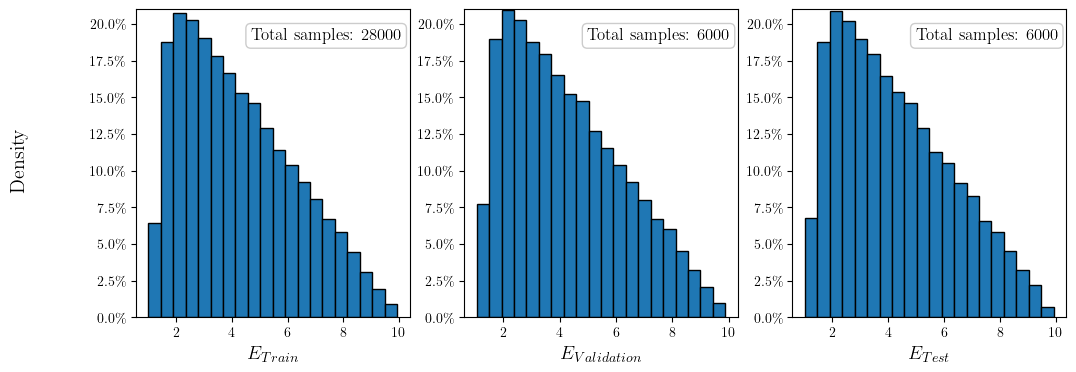

In [17]:
test_ratio = 0.15
# (!!!) validation ratio is currently given in relation to the entire dataset (!!!!)
valid_ratio = 0.15
rnd_state = 42
# 350, 1000, 1100, 7650
# Without stratify
# x_train, x_test, y_train, y_test = train_test_split(x_hc, y_hc, test_size=test_ratio, random_state=rnd_state, stratify=None)
# x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=valid_ratio/(1-test_ratio), random_state=rnd_state, stratify=None)

# With stratify
bin_count = 100
bins = pd.qcut(y_hc, bin_count, labels=False, duplicates='drop')
x_train, x_test, y_train, y_test = train_test_split(x_hc, y_hc, test_size=test_ratio,
                                                     random_state=rnd_state, stratify = bins)

bins = pd.qcut(y_train, bin_count, labels=False, duplicates='drop')
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=valid_ratio/(1-test_ratio),
                                                       random_state=rnd_state, stratify = bins)

# Create list of nested arrays [np.array(features), np.array(labels)] to later be saved as pkl for each train
dataset = [x_train, y_train, x_valid, y_valid, x_test, y_test]



fig, ax = plt.subplots(1,3, figsize=(12,4))
dens = True
xlabel_list_hertz = ['$E_{Train}$', '$E_{Validation}$', '$E_{Test}$']
if dens:
    fig.supylabel('Density')
else:
    fig.supylabel('Frequency')
for ix, sp in enumerate(ax):
    sp.set_xlabel(xlabel_list_hertz[ix], fontsize=14)
    sp.yaxis.set_major_formatter(PercentFormatter(1))
# set y limit in all subplots

props = dict(boxstyle='round', facecolor='white', alpha=0.2)
ax[0].hist(y_train, 20, ec='black', density=dens)
ax[0].set_ylim((0,0.21))
ax0 = len(y_train)
ax[0].text(0.42, 0.9, f'Total samples: {ax0}', transform=ax[0].transAxes, fontsize=12, bbox=props)
ax[1].hist(y_valid, 20, ec='black', density=dens)
ax[1].set_ylim((0,0.21))
ax1 = len(y_test)
ax[1].text(0.45, 0.9, f'Total samples: {ax1}', transform=ax[1].transAxes, fontsize=12, bbox=props)
ax[2].hist(y_test, 20, ec='black', density=dens)
ax[2].set_ylim((0,0.21))
ax2 = len(y_test)
ax[2].text(0.45, 0.9, f'Total samples: {ax2}', transform=ax[2].transAxes, fontsize=12, bbox=props)


# plt.savefig('hist_unstrat.pdf')

x_train.shape, x_valid.shape, x_test.shape, y_train.shape, x_train, y_test

## ML

In [18]:
# Training and test data from np arrays to torch tensor with desired shape
def tensor_input_shape(nparray):
    '''
    Input: nparray - numpy array with two dimensions (n_samples, n_features)
    Output: torch_tensor - pytorch tensor with 3 dimensions (n_samples, n_pts, n_features) 
    '''
    n_samples = len(nparray)
    n_pts = len(nparray[0,0])
    torch_tensor = torch.zeros(size=(n_samples, n_pts, 2))
    for i in range(n_samples):
        aux_nparray = np.hstack((np.array(nparray[i,0]).reshape((n_pts,1)), np.array(nparray[i,1]).reshape((n_pts,1))))
        aux_ttensor = torch.from_numpy(aux_nparray).type(torch.float)
        torch_tensor[i,:,:] = aux_ttensor
    return torch_tensor

x_train_t = tensor_input_shape(x_train)
x_valid_t = tensor_input_shape(x_valid)
x_test_t = tensor_input_shape(x_test)
y_train_t = torch.from_numpy(y_train).type(torch.float).unsqueeze(dim=1)
y_valid_t = torch.from_numpy(y_valid).type(torch.float).unsqueeze(dim=1)
y_test_t = torch.from_numpy(y_test).type(torch.float).unsqueeze(dim=1)
#x_train_t2 = torch.from_numpy(x_train).type(torch.float)

x_train_t.shape, y_train_t.shape


(torch.Size([28000, 50, 2]), torch.Size([28000, 1]))

In [19]:
# Auxiliary functions

def create_model_dir(timestamp, contact_model: str):

  ''' Second input must be 'hertz' or 'jkr' '''
  
  allowed_models = ['hertz', 'jkr']
  if contact_model not in allowed_models:
    raise ValueError("Input value must be one of %s" % allowed_models)
  model_path = 'model_{}'.format(timestamp)
  parent_dir = 'c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese'
  if contact_model == 'hertz':
    dir = 'Hertz_models'
  elif contact_model == 'jkr':
    dir = 'JKR_models'
  path = os.path.join(parent_dir, dir, model_path)
  # path = os.path.join(initial_wd, dir, model_path)
  os.mkdir(path)
  os.chdir(path)

def data_as_pkl(dataset_list: list):
  file_names = ['x_train', 'y_train', 'x_valid', 'y_valid', 'x_test', 'y_test']
  new_dir = 'Train_Validation_Data'
  current_path = os.getcwd()
  os.mkdir(new_dir)
  os.chdir(new_dir)
  for i, array in enumerate(dataset_list):
    with open(file_names[i]+'.pkl', 'wb') as f:
      pickle.dump(array, f)
  os.chdir(current_path)

def plot_loss_curve(epochs, mse_training, mse_validation, loss: bool):
  plt.figure()
  plt.xlabel("Epoch")
  if loss:
    plt.ylabel("Loss")
    plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
    plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  else:
    plt.ylabel("Error (\%)")
    plt.plot(epochs[0:], mse_training[0:], label="Training Error")
    plt.plot(epochs[0:], mse_validation[0:], label="Validation Error")    
  plt.legend()  
  # We're not going to plot the first epoch (>>greater loss)
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  top_of_y_axis = highest_loss + (delta * 0.2)
  bottom_of_y_axis = lowest_loss - (delta * 0.2)   
  if loss:
    plt.yscale('log')
    plt.savefig('loss_plot.pdf') 
  else:
    plt.ylim([bottom_of_y_axis, top_of_y_axis])
    plt.savefig('error_plot.pdf')
  # plt.show()

def plot_error_hist(error_list, test: bool, **kwargs):
  '''**kwargs: percentage of curves with errors under x%. 
              The values must be provided for errors in ascending order (error2_5 = y, error10 = z)'''
  fig, ax = plt.subplots()
  plt.figure()
  x_values = [2.5, 10]
  error_values = list(kwargs.values())
  ax.hist(error_list, bins=20, density=True, ec='black', range=(0,20)) # to remove outliers, set parameter 'range='
  ax.set_xlabel("Error (\%)")
  ax.set_ylabel("Density")
  #plt.gca().yaxis.set_major_formatter(PercentFormatter(1)) # set y axis as %
  ax.yaxis.set_major_formatter(PercentFormatter(1))
  if test:
    ax.axvline(x_values[0], color='red', linestyle='--', label=f'{error_values[0]*100: .1f}\% of curves with $\epsilon<2.5\%$')
    ax.axvline(x_values[1], color='green', linestyle='--', label=f'{error_values[1]*100: .1f}\% of curves with $\epsilon<10\%$')
    ax.legend(loc='center', ncol=2, bbox_to_anchor=(0.5, 1.05), fontsize=13)
    ax.text(0.76, 0.95, f'Num. of tested curves: {len(error_list)}', transform=ax.transAxes, fontsize=12, ha='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))
    # ax.set_title("Test error")
    fig.savefig('error_hist_test.pdf')
  else:
    fig.savefig('error_hist_valid.pdf') 
  # plt.show()

def plot_bad_curves(verror_list, list_inputs, list_labels, test: bool):
  bad_curves = [(i, j) for i, j in enumerate(verror_list) if j > 15] # Gets index and error value of all errors above 15%
  if len(bad_curves) < 5: 
    all_curves_sorted = sorted([(i, j) for i, j in enumerate(verror_list)], key= lambda k:k[1], reverse=True) # sorts error list, keeping i (the original index of each error value)
    for i in range(5-len(bad_curves)):
        bad_curves.append(all_curves_sorted[len(bad_curves)+i])
  plt.figure()
  for j, (i, _) in enumerate(bad_curves):
    if j < 5:
      tensor_idx = i//len(list_inputs[0])
      tensor_fts, tensor_labels = list_inputs[tensor_idx], list_labels[tensor_idx]
      plt.plot(tensor_fts[i-tensor_idx*len(list_inputs[0]),:,0].numpy(),
              tensor_fts[i-tensor_idx*len(list_inputs[0]),:,1].numpy(),
              alpha=0.75,
              label=f'E={round(tensor_labels[i-tensor_idx*len(list_inputs[0])].item(),3)} kPa, $\epsilon$={verror_list[i]: .2f}\%')
  
  plt.xlabel('Indentation (nm)')
  plt.ylabel('Force (nN)')
  plt.legend()
  ax = plt.axis()
  plt.axis((ax[1],ax[0],ax[2],ax[3]))
  if test:
    plt.savefig('bad_curves_test.pdf')
  else:
    plt.savefig('bad_curves_valid.pdf')

def plot_pred_real_curves(verror_list, list_inputs, list_labels, test: bool, list_predicts, nu, r):
  bad_curves = []
  bad_curves_15 = sorted([(i, j) for i, j in enumerate(verror_list) if j > 15], key= lambda k:k[1], reverse=True)
  bad_curves_10 = sorted([(i, j) for i, j in enumerate(verror_list) if j < 10], key= lambda k:k[1], reverse=True)
  bad_curves_2 = sorted([(i, j) for i, j in enumerate(verror_list) if j < 2], key= lambda k:k[1], reverse=True)
  all_bad_curves = [bad_curves_15, bad_curves_10, bad_curves_2]
  for curve in all_bad_curves:
    if len(curve) >=1:
      bad_curves.append(curve[0])
  # plt.figure()
  fig, ax = plt.subplots()
  colors = ['red','blue', 'green']
  line_styles = ['-', ':']
  for j, (i, _) in enumerate(bad_curves):
    tensor_idx = i//len(list_inputs[0])
    tensor_fts, tensor_labels, tensor_predicts = list_inputs[tensor_idx], list_labels[tensor_idx], list_predicts[tensor_idx]
    x = tensor_fts[i-tensor_idx*len(list_inputs[0]),:,0].numpy()
    y1 = tensor_fts[i-tensor_idx*len(list_inputs[0]),:,1].numpy()
    predict = tensor_predicts[i-tensor_idx*len(list_inputs[0])].item()
    y2 = hertz(x, predict, nu, r)
    ax.plot(x,
             y1,
             alpha=0.75,
             label='$E_{Real}$'+f'={round(tensor_labels[i-tensor_idx*len(list_inputs[0])].item(),1)} kPa, $\epsilon$={verror_list[i]: .1f} \%',
             color=colors[j], linestyle=line_styles[0])
    ax.plot(x,
             y2,
             color=colors[j], linestyle=line_styles[1])
    color_legend = ax.legend()
  dummy_lines = []
  for k in range(2):
      dummy_lines.append(ax.plot([],[], c="black", ls = line_styles[k])[0])
  bbox_y = [0.85, 0.79, 0.73]
  linestyle_legend = plt.legend([dummy_lines[i] for i in [0,1]], ["Real curve", "Predicted Curve"], loc=7, bbox_to_anchor=(1.,bbox_y[len(bad_curves)-1]))
  # line_legend = ax.legend(loc='right')
  plt.xlabel('Indentation (nm)')
  plt.ylabel('Force (nN)')
  # plt.legend()
  ax.add_artist(color_legend)
  ax.add_artist(linestyle_legend)
  # put the legends in separate boxes
  color_legend.get_frame().set_facecolor('white')
  color_legend.get_frame().set_edgecolor('black')
  linestyle_legend.get_frame().set_facecolor('white')
  linestyle_legend.get_frame().set_edgecolor('black')
  # ax.add_artist(line_legend)
  ax2 = ax.axis()
  ax.axis((ax2[1],ax2[0],ax2[2],ax2[3]))
  if test:
    fig.savefig('test_pred_vs_real_curves.pdf')
  else:
    fig.savefig('valid_pred_vs_real_curves.pdf') 

def error_fn(predict_tensor, label_tensor):
  '''
  INPUTS: * two tensors - true labels and predicts
  OUTPUTS: * scalar - mean relative error (in %) between both tensors
           * list - relative error (%) for each prediction
  '''
  error = abs((label_tensor-predict_tensor)/label_tensor*100).squeeze(dim=1).mean().item()
  error_list = list(abs((label_tensor-predict_tensor)/label_tensor*100).squeeze(dim=1).detach().numpy())
  return error, error_list


In [20]:
class Hertz_Dataset():
  
  def __init__(self,features,labels):
    self.features = features
    self.labels = labels
 
  def __len__(self):
    return len(self.labels)
   
  def __getitem__(self,idx):
    return self.features[idx],self.labels[idx]

In [21]:
train_data = Hertz_Dataset(x_train_t, y_train_t)
test_data = Hertz_Dataset(x_test_t, y_test_t)
valid_data = Hertz_Dataset(x_valid_t, y_valid_t)

In [22]:
################ After changing one of the hyperparameters: ########################
### Re-run the cells where the model class and the model_params dict are defined ###

# HYPERPARAMETERS
LEARNING_RATE = 2.30e-4
EPOCHS = 10
BATCH_SIZE = 16

# Size of each layer
HIDDEN_UNITS_1 = 256
HIDDEN_UNITS_2 = 256
HIDDEN_UNITS_3 = 32

# 1: 2 layers, 2: 3 layers
ARCHITECTURE = 1


In [23]:
train_loader=DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=True)
test_loader=DataLoader(test_data, batch_size=int(test_ratio*size+1),shuffle=False)
valid_loader=DataLoader(valid_data, batch_size=int(valid_ratio*size+1), shuffle=False)

### Regression Model

In [24]:
# Define the linear regression model
class Regression_Hertz(nn.Module):
    def __init__(self, input_shape, HIDDEN_UNITS_1, HIDDEN_UNITS_2, HIDDEN_UNITS_3):
        super(Regression_Hertz, self).__init__()
        input_size = input_shape[0] * input_shape[1]
        self.layers = nn.Sequential(nn.Flatten(),
                                    nn.Linear(input_size, HIDDEN_UNITS_1),
                                    nn.LeakyReLU(), # Change model parameters and in draft.py
                                    nn.Linear(HIDDEN_UNITS_1,HIDDEN_UNITS_2),
                                    nn.LeakyReLU(),
                                    nn.Linear(HIDDEN_UNITS_2, HIDDEN_UNITS_3),
                                    nn.LeakyReLU(),
                                    nn.Linear(HIDDEN_UNITS_3, 1))
    def forward(self, x):
        out = self.layers(x)
        return out
# Define input shape
input_shape = x_train_t.shape[1:]
# Instantiate the model
torch.manual_seed(42)
model_Hertz = Regression_Hertz(input_shape, HIDDEN_UNITS_1, HIDDEN_UNITS_2, HIDDEN_UNITS_3)

# Define the loss function and optimizer
loss_fn = nn.HuberLoss()
optimizer = torch.optim.Adam(model_Hertz.parameters(), 
                            lr=LEARNING_RATE)


In [25]:
def train_one_epoch(epoch_index, train_loader): # (epoch_index, tb_writer)
    # running_loss = 0.
    # last_loss = 0.
    loss_list = []
    error_list = []
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_Hertz(inputs)
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        error, _ = error_fn(outputs, labels)
        loss.backward()
        # Adjust learning weights
        optimizer.step()
        # Gather data and report
        loss_list.append(loss.item())
        error_list.append(error)
        # running_loss += loss.item()  # .item() converts tensor to number
        # print(i, loss.item())
    return loss_list, error_list

In [26]:
model_params = {'Epochs': EPOCHS, 
                'Learning Rate': LEARNING_RATE,
                'Batch Size': BATCH_SIZE,
                'Number of Hidden layers': ARCHITECTURE+1,
                'Type of layers': nn.Linear,
                'Activation function': nn.LeakyReLU(),
                'Architecture': ARCHITECTURE,
                'Hidden Units 1': HIDDEN_UNITS_1,
                'Hidden Units 2': HIDDEN_UNITS_2,
                'Hidden Units 3': HIDDEN_UNITS_3,
                'Input shape': list(input_shape),
                'Loss function': loss_fn,
                'Optimizer': optimizer,
                'nu': nu,
                'radius': r,
                'xmax': xmax}
model_params

{'Epochs': 10,
 'Learning Rate': 0.00023,
 'Batch Size': 16,
 'Number of Hidden layers': 2,
 'Type of layers': torch.nn.modules.linear.Linear,
 'Activation function': LeakyReLU(negative_slope=0.01),
 'Architecture': 1,
 'Hidden Units 1': 256,
 'Hidden Units 2': 256,
 'Hidden Units 3': 32,
 'Input shape': [50, 2],
 'Loss function': HuberLoss(),
 'Optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.00023
     maximize: False
     weight_decay: 0
 ),
 'nu': 0.5,
 'radius': 1980.0,
 'xmax': 150}

In [27]:
'''summary(model = model_Hertz,
        input_size=(16,50,2),
        col_names = ["input_size", "output_size", "num_params"],
        col_width=20,
        row_settings=["var_names"])'''

'''import torchview
from torchview import draw_graph

model_graph = draw_graph(model_Hertz, input_size = (BATCH_SIZE, 50, 2), save_graph=True)
print(os.getcwd())
model_graph.visual_graph'''

'import torchview\nfrom torchview import draw_graph\n\nmodel_graph = draw_graph(model_Hertz, input_size = (BATCH_SIZE, 50, 2), save_graph=True)\nprint(os.getcwd())\nmodel_graph.visual_graph'

In [28]:
def train_model_Hertz(EPOCHS: int,
                      model_Hertz,
                      train_loader,
                      valid_loader,
                      loss_fn,
                      optimizer,
                      x_test_t, y_test_t,
                      dataset_list: list
                      ):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    # Set new directory for new model
    initial_wd = os.getcwd()
    create_model_dir(timestamp, contact_model='hertz')
    best_vloss = 1_000_000.
    cols = ['Epoch', 'Train Loss', 'Mean Train Loss', 'Mean Val Loss', 'Train Error (%)', 'Mean Train Error (%)', 'Mean Val Error (%)']
    row = []
    # start timer counter
    start = datetime.now()
    for epoch in range(EPOCHS):
        # print('EPOCH {}:'.format(epoch + 1))
        # Make sure gradient tracking is on, and do a pass over the data
        model_Hertz.train(True)
        loss_list, error_list = train_one_epoch(epoch, train_loader) # (epoch, writer)
        # We don't need gradients on to do reporting
        model_Hertz.train(False)
        running_vloss = 0.0
        running_verror = 0.0
        verror_list, fts_list, labels_list, predicts_list = [], [], [], []
        for i, vdata in enumerate(valid_loader):
            vinputs, vlabels = vdata
            fts_list.append(vinputs)
            labels_list.append(vlabels)
            voutputs = model_Hertz(vinputs)
            predicts_list.append(voutputs)
            vloss = loss_fn(voutputs, vlabels)
            verror, verror_aux_list = error_fn(voutputs, vlabels)
            running_vloss += vloss
            running_verror += verror
            verror_list += verror_aux_list
        avg_vloss = running_vloss / (i + 1)
        avg_verror = running_verror / (i + 1)
        row.append(dict(zip(cols, 
                            [epoch+1, 
                            loss_list, 
                            np.array(loss_list).mean(), 
                            avg_vloss.item(), 
                            error_list, 
                            np.array(error_list).mean(), 
                            avg_verror])))
        # Track best performance
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'model_state_dict_{}_{}.pt'.format(timestamp, epoch+1)
            #torch.save(model_Hertz.state_dict(), model_path)
            verror_list_best = verror_list
            fts_list_best = fts_list
            labels_list_best = labels_list
            predicts_list_best = predicts_list
    end = datetime.now()
    model_params['Training Time'] = end - start
    print('Training time: {}'.format(model_params['Training Time']))
    torch.save(model_Hertz.state_dict(), model_path)
    model_params['Model Path'] = model_path
    df = pd.DataFrame(row)
    df.to_csv('loss_error.csv', index=False)
    plot_loss_curve(df['Epoch'].values.tolist(), df['Mean Train Loss'].values.tolist(), df['Mean Val Loss'].values.tolist(), loss=True)
    plot_loss_curve(df['Epoch'].values.tolist(), df['Mean Train Error (%)'].values.tolist(), df['Mean Val Error (%)'].values.tolist(), loss=False)
    plot_bad_curves(verror_list_best, fts_list_best, labels_list_best, test=False)
    plot_pred_real_curves(verror_list_best, fts_list_best, labels_list_best, test=False, list_predicts=predicts_list_best, nu=nu, r=r)
    plot_error_hist(verror_list_best, test=False)
    with open('model_params.csv', 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = model_params.keys())
        writer.writeheader()
        writer.writerow(model_params)
    torch.save(x_test_t, 'x_test_t.pt')
    torch.save(y_test_t, 'y_test_t.pt')
    data_as_pkl(dataset_list)
    os.chdir(initial_wd)

In [29]:
# plt.ioff()
# train_model_Hertz(EPOCHS, model_Hertz, train_loader, valid_loader, loss_fn, optimizer, x_test_t, y_test_t, dataset)

([<matplotlib.axis.XTick at 0x1d5915d0280>,
 [Text(20, 0, '$\\mathdefault{20}$'),
  Text(40, 0, '$\\mathdefault{40}$'),
  Text(60, 0, '$\\mathdefault{60}$')])

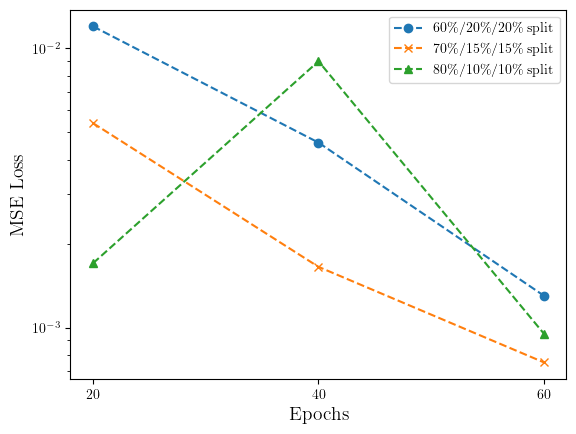

In [30]:
# Boxplots overlayed
s60 = [0.012, 0.0046, 0.0013]
s70 = [0.0054, 0.00165, 0.00075]
s80 = [0.0017, 0.009, 0.00095]

x = [20,40,60]

plt.plot(x, s60, label="$60\%/20\%/20\%$ split", marker='o', linestyle='--')
plt.plot(x, s70, label="$70\%/15\%/15\%$ split", marker='x', linestyle='--')
plt.plot(x, s80, label="$80\%/10\%/10\%$ split", marker='^', linestyle='--')
plt.legend()


# y axis in log scale
plt.yscale('log')
# y label
plt.ylabel('MSE Loss', fontsize=14)
# x label
plt.xlabel('Epochs', fontsize=14)
# x ticks only for 20, 40 and 60
plt.xticks(x)
# save plot as pdf
# plt.savefig('loss_split_epoch.pdf')

# -------------------------------------------------------------------
# -------------------------------------------------------------------
# -------------------------------------------------------------------
# -------------------------------------------------------------------
# -------------------------------------------------------------------
# **JKR**

In [31]:
#dataframe with contact-only data
#df_jkr: dataframe for jkr data
df_jkr = pd.DataFrame()
df_jkr['withdraw'] = df['withdraw'].copy()
df_jkr['withdraw_contact'] = df_jkr['withdraw'].copy().apply(lambda x: x[x>0])
df_jkr['f_jkr'] = df['f_jkr'].copy()
df_jkr['f_jkr_contact'] = df_jkr['f_jkr'].copy().apply(lambda x: x[:-(len(no_contact))])
df_jkr['E_jkr'] = df['E'].copy()
df_jkr['gamma_jkr'] = df['gamma'].copy()

#check size of disp and force vectors
print(df_jkr['withdraw_contact'][0].shape, df_jkr['f_jkr_contact'][0].shape)

(50,) (50,)


In [810]:
def create_model_dir(timestamp, contact_model: str):

  ''' Second input must be 'hertz' or 'jkr' '''
  
  allowed_models = ['hertz', 'jkr']
  if contact_model not in allowed_models:
    raise ValueError("Input value must be one of %s" % allowed_models)
  model_path = 'model_{}'.format(timestamp)
  parent_dir = 'c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese'
  if contact_model == 'hertz':
    dir = 'Hertz_models'
  elif contact_model == 'jkr':
    dir = 'JKR_models'
  path = os.path.join(parent_dir, dir, model_path)
  # path = os.path.join(initial_wd, dir, model_path)
  os.mkdir(path)
  os.chdir(path)

In [811]:
def plot_loss_curve2(epochs, mse_training, mse_validation, loss: bool, E:bool, gamma:bool):
  plt.figure()
  plt.xlabel("Epoch")
  if loss:
    if E:
      plt.title("$E$", fontsize=16)
    elif gamma:
      plt.title("$\gamma$", fontsize=16)
    plt.ylabel("Loss")
    plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
    plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  else:
    if E:
      plt.title("$E$", fontsize=16)
    elif gamma:
      plt.title("$\gamma$", fontsize=16)
    plt.ylabel("Error (\%)")
    plt.plot(epochs[0:], mse_training[0:], label="Training Error")
    plt.plot(epochs[0:], mse_validation[0:], label="Validation Error")    
  plt.legend()
  # We're not going to plot the first epoch (>>greater loss)
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  top_of_y_axis = highest_loss + (delta * 0.2)
  bottom_of_y_axis = lowest_loss - (delta * 0.2)   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  if loss:
    if E:
      plt.savefig('loss_plot_E.pdf')
    elif gamma:
      plt.savefig('loss_plot_gamma.pdf')
    else:
      plt.savefig('loss_plot.pdf') 
  else:
    if E:
      plt.savefig('error_plot_E.pdf')
    elif gamma:
      plt.savefig('error_plot_gamma.pdf')
  plt.show()

def plot_bad_curves2(verror_list_E, verror_list_gamma, list_inputs, list_labels, test: bool):
  verror_arr_E = np.array(verror_list_E)
  verror_arr_gamma = np.array(verror_list_gamma)
  v_error_arr = np.vstack((verror_arr_E, verror_arr_gamma)).T
  bad_curves = [(i, j) for i, j in enumerate(v_error_arr) if j[0] > 15 and j[1] > 15] # Gets index and error value of all errors above 15%
  if len(bad_curves) > 5:
    bad_curves = sorted(bad_curves, key= lambda k:max(k[1]), reverse=True)[:5]
  if len(bad_curves) < 5: 
    all_curves_sorted = sorted([(i, j) for i, j in enumerate(v_error_arr)], key= lambda k:max(k[1]), reverse=True) # sorts error list, keeping i (the original index of each error value)
    for i in range(5-len(bad_curves)):
        bad_curves.append(all_curves_sorted[len(bad_curves)+i])
  plt.figure()
  for j, (i, _) in enumerate(bad_curves):
      tensor_idx = i//len(list_inputs[0])
      tensor_fts, tensor_labels = list_inputs[tensor_idx], list_labels[tensor_idx]
      plt.plot(tensor_fts[i-tensor_idx*len(list_inputs[0]),:,0].numpy(),
              tensor_fts[i-tensor_idx*len(list_inputs[0]),:,1].numpy(),
              alpha=0.75,
              label=f'$E$={round(tensor_labels[i-tensor_idx*len(list_inputs[0]),0].item(),2)} kPa, $\epsilon_E$={verror_list_E[i]: .1f}\%, '+
                    f'$\gamma$={round(tensor_labels[i-tensor_idx*len(list_inputs[0]),1].item(),2)} $\mu$J/m$^2$, $\epsilon_\gamma$={verror_list_gamma[i]: .1f}\%')
  plt.xlabel('Indentation (nm)')
  plt.ylabel('Force (nN)')
  plt.legend()
  ax = plt.axis()
  plt.axis((ax[1],ax[0],ax[2],ax[3]))
  if test:
    plt.savefig('bad_curves_test.pdf')
  else:
    plt.savefig('bad_curves_valid.pdf')

def plot_error_hist2(error_list, test: bool, E:bool, **kwargs):
  '''**kwargs: percentage of curves with errors under x%. 
              The values must be provided for errors in ascending order (error2_5 = y, error10 = z)'''
  # Define variable name to be introduced in the file name of the final plots
  if E:
    var_name = 'E'
  else:
    var_name = 'gamma'
  fig, ax = plt.subplots()
  plt.figure()
  x_values = [2.5, 10]
  error_values = list(kwargs.values())
  ax.hist(error_list, bins=20, density=True, ec='black', range=(0,20)) # to remove outliers, set parameter 'range='
  if E:
    ax.set_title("$E$", fontsize=16, y=1.08)
  else:
    ax.set_title("$\gamma$", fontsize=16, y=1.08)
  ax.set_xlabel("Error (\%)")
  ax.set_ylabel("Density")
  #plt.gca().yaxis.set_major_formatter(PercentFormatter(1)) # set y axis as %
  ax.yaxis.set_major_formatter(PercentFormatter(1))
  if test:
    ax.axvline(x_values[0], color='red', linestyle='--', label=f'{error_values[0]*100: .1f}\% of curves with $\epsilon<2.5\%$')
    ax.axvline(x_values[1], color='green', linestyle='--', label=f'{error_values[1]*100: .1f}\% of curves with $\epsilon<10\%$')
    ax.legend(loc='center', ncol=2, bbox_to_anchor=(0.5, 1.05))
    ax.text(0.76, 0.95, f'Num. of tested curves: {len(error_list)}', transform=ax.transAxes, fontsize=12, ha='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))
    # ax.set_title("Test error")
    fig.savefig(f'error_hist_test_{var_name}.pdf')
  else:
    fig.savefig(f'error_hist_valid_{var_name}.pdf') 
  plt.show()

def plot_pred_real_curves2(verror_list_E, verror_list_gamma, list_inputs, list_labels, test: bool, list_predicts, nu, r, E:bool):
  ''' Takes the list of errors and plots the curves with errors above 15%, and close to 10% and 2.5%.
      If plotting E, the list of errors for E is used, and only curves with gamma error below 2% are considered (and vice-versa).
      Inputs:
        - verror_list_E: list of errors for E 
        - verror_list_gamma: list of errors for gamma
        - list_inputs: list of tensors with inputs
        - list_labels: list of tensors with labels
        - test: boolean, True if test set, False if validation set
        - list_predicts: list of tensors with predictions
        - nu: Poisson's ratio
        - r: radius of the tip
        - E: boolean, True if plotting E, False if plotting gamma  
  '''
  if E:
    var_name = 'E'
    idx = 0
    verror_list = verror_list_E
    verror_list2 = verror_list_gamma
  else:
    var_name = 'gamma'
    idx = 1
    verror_list = verror_list_gamma
    verror_list2 = verror_list_E
  # Get all index of the values in verror_list2 that are below 2%
  good_curves_2 = [i for i, j in enumerate(verror_list2) if j < 2.5]
  # Select the curves in verror_list with index i in good_curves_2
  verror_list = [verror_list[i] for i in good_curves_2]
  bad_curves = []
  bad_curves_15 = sorted([(i, j) for i, j in enumerate(verror_list) if j > 15], key= lambda k:k[1], reverse=True)
  bad_curves_10 = sorted([(i, j) for i, j in enumerate(verror_list) if j < 10], key= lambda k:k[1], reverse=True)
  bad_curves_2 = sorted([(i, j) for i, j in enumerate(verror_list) if j < 2], key= lambda k:k[1], reverse=True)
  all_bad_curves = [bad_curves_15, bad_curves_10, bad_curves_2]
  for curve in all_bad_curves:
    if len(curve) >=1:
      bad_curves.append(curve[0])
  # plt.figure()
  fig, ax = plt.subplots()
  colors = ['red','blue', 'green']
  line_styles = ['-', ':']
  for j, (i, _) in enumerate(bad_curves):
    tensor_idx = i//len(list_inputs[0])
    tensor_fts, tensor_labels, tensor_predicts = list_inputs[tensor_idx], list_labels[tensor_idx][0], list_predicts[tensor_idx][0]
    x = tensor_fts[i-tensor_idx*len(list_inputs[0]),:,0].numpy()
    y1 = tensor_fts[i-tensor_idx*len(list_inputs[0]),:,1].numpy()
    predict = tensor_predicts[i-tensor_idx*len(list_inputs[0]), idx].item()
    y2 = hertz(x, predict, nu, r)
    if E:
      ax.set_title("$E$", fontsize=16)
      ax.plot(x,
              y1,
              alpha=0.75,
              label='$E_{Real}$'+f'={round(tensor_labels[i-tensor_idx*len(list_inputs[0]), 0].item(),3)} kPa, $\epsilon_E$={verror_list[i]: .2f} \%',
              color=colors[j], linestyle=line_styles[0])
    else:
      ax.set_title("$\gamma$", fontsize=16)
      ax.plot(x,
              y1,
              alpha=0.75,
              label='$\gamma_{Real}$'+f'={round(tensor_labels[i-tensor_idx*len(list_inputs[0]), 1].item(),3)} $\mu$J/m$^2$, $\epsilon_\gamma$={verror_list[i]: .2f} \%',
              color=colors[j], linestyle=line_styles[0])
    ax.plot(x,
             y2,
             color=colors[j], linestyle=line_styles[1])
    color_legend = ax.legend()
  dummy_lines = []
  for k in range(2):
      dummy_lines.append(ax.plot([],[], c="black", ls = line_styles[k])[0])
  bbox_y = [0.85, 0.79, 0.73]
  linestyle_legend = plt.legend([dummy_lines[i] for i in [0,1]], ["Real curve", "Predicted Curve"], loc=7, bbox_to_anchor=(1.,bbox_y[len(bad_curves)-1]))
  # line_legend = ax.legend(loc='right')
  plt.xlabel('Indentation (nm)')
  plt.ylabel('Force (nN)')
  # plt.legend()
  ax.add_artist(color_legend)
  ax.add_artist(linestyle_legend)
  # put the legends in separate boxes
  color_legend.get_frame().set_facecolor('white')
  color_legend.get_frame().set_edgecolor('black')
  linestyle_legend.get_frame().set_facecolor('white')
  linestyle_legend.get_frame().set_edgecolor('black')
  # ax.add_artist(line_legend)
  ax2 = ax.axis()
  ax.axis((ax2[1],ax2[0],ax2[2],ax2[3]))
  if test:
      fig.savefig(f'test_pred_vs_real_curves_{var_name}.pdf')
  else:
      fig.savefig(f'valid_pred_vs_real_curves_{var_name}.pdf')


In [63]:
def get_mean_std(series: pd.Series):
    return series.mean(), series.std()

def get_max_min(series: pd.Series):
    return series.max(), series.min()

def normalize(x, min, max):
    return (x-min)/(max-min)

def unnormalize(x, min, max):
    return min + x*(max-min)

get_mean_std(df_jkr['E_jkr']), get_mean_std(df_jkr['gamma_jkr']), get_max_min(df_jkr['E_jkr']), get_max_min(df_jkr['gamma_jkr'])

((4.261169501887732, 2.0293377798064034),
 (2.000510493831623, 0.5756294452885138),
 (9.925516580962116, 1.0063137995940286),
 (2.9999442947359647, 1.0000168644226086))

In [64]:
e_max, e_min = get_max_min(df_jkr['E_jkr'])
gamma_max, gamma_min = get_max_min(df_jkr['gamma_jkr'])



'''df_jkr_norm = pd.DataFrame()
df_jkr_norm = df_jkr.copy().drop(['E_jkr', 'gamma_jkr'], axis=1)
df_jkr_norm['E_jkr_norm'] = df_jkr['E_jkr'].copy().apply(lambda x: normalize(x, e_min, e_max))
df_jkr_norm['gamma_jkr_norm'] = df_jkr['gamma_jkr'].copy().apply(lambda x: normalize(x, gamma_min, gamma_max))'''

df_jkr.head()

,withdraw,withdraw_contact,f_jkr,f_jkr_contact,E_jkr,gamma_jkr
0,"[150.0, 147.0, 144.0, 141.0, 138.0, 135.0, 132...","[150.0, 147.0, 144.0, 141.0, 138.0, 135.0, 132...","[0.2992271987955676, 0.28782651087970235, 0.27...","[0.2992271987955676, 0.28782651087970235, 0.27...",3.205963,1.597824
1,"[150.0, 143.64657852132757, 142.4352780999585,...","[150.0, 143.64657852132757, 142.4352780999585,...","[0.9475943909982655, 0.8809665300913578, 0.868...","[0.9475943909982655, 0.8809665300913578, 0.868...",8.092833,1.189636
2,"[150.0, 145.96271699783, 145.76333541182936, 1...","[150.0, 145.96271699783, 145.76333541182936, 1...","[0.6127145506428551, 0.584290117271191, 0.5828...","[0.6127145506428551, 0.584290117271191, 0.5828...",5.552658,1.252718
3,"[150.0, 149.10283749624375, 147.6195141561324,...","[150.0, 149.10283749624375, 147.6195141561324,...","[0.47890547049892457, 0.47379551073464715, 0.4...","[0.47890547049892457, 0.47379551073464715, 0.4...",4.557666,1.361342
4,"[150.0, 144.79045779182758, 143.8533839693698,...","[150.0, 144.79045779182758, 143.8533839693698,...","[0.17948521607637669, 0.16698477260297337, 0.1...","[0.17948521607637669, 0.16698477260297337, 0.1...",2.107863,1.407307


### Train_test_validation split

In [33]:
test_ratio_jkr = 0.15
valid_ratio_jkr = 0.15
# rnd state for the unstrar distribution: 50
# rnd states for plit tests: 42, 50, 100
rnd_state_jkr = 42
# SEE INTERSTRAT.ML_STRATIFIERS

target_cols = ['E_jkr_cat', 'gamma_jkr_cat']
nbins = 30

# Split without stratification
# train_df_jkr, test_df_jkr = train_test_split(df_jkr, test_size=test_ratio_jkr, random_state=50)
# train_df_jkr, valid_df_jkr = train_test_split(train_df_jkr, test_size=valid_ratio_jkr/(1-test_ratio_jkr), random_state=50)

print('Split 1')
while nbins >= 1:
    print(nbins)
    try:
        df_jkr['E_jkr_cat'] = pd.cut(df_jkr['E_jkr'], bins=nbins)
        df_jkr['gamma_jkr_cat'] = pd.cut(df_jkr['gamma_jkr'], bins=nbins)
        train_df_jkr, test_df_jkr = train_test_split(df_jkr, test_size=test_ratio_jkr, 
                                             stratify=df_jkr[target_cols], random_state=rnd_state_jkr)
        break
    except:
        nbins += -1
print('Split 2')
nbins = 30
while nbins >= 1:
    print(nbins)
    try:
        train_df_jkr, valid_df_jkr = train_test_split(train_df_jkr, test_size=valid_ratio_jkr/(1-test_ratio_jkr), 
                                             stratify=train_df_jkr[target_cols], random_state=rnd_state_jkr)
        break
    except:
        nbins += -1
        
'''while nbins >= 2:
    print(nbins)
    try:
        df_jkr_norm['E_jkr_cat'] = pd.cut(df_jkr_norm['E_jkr_norm'], bins=nbins)
        df_jkr_norm['gamma_jkr_cat'] = pd.cut(df_jkr_norm['gamma_jkr_norm'], bins=nbins)
        train_df_jkr_norm, test_df_jkr_norm = train_test_split(df_jkr_norm, test_size=test_ratio, 
                                             stratify=df_jkr_norm[target_cols], random_state=rnd_state_jkr)
        break
    except:
        nbins += -1

while nbins >= 2:
    print(nbins)
    try:
        train_df_jkr_norm, valid_df_jkr_norm = train_test_split(train_df_jkr_norm, test_size=valid_ratio_jkr/(1-test_ratio_jkr), 
                                             stratify=train_df_jkr_norm[target_cols], random_state=rnd_state_jkr)
        break
    except:
        nbins += -1'''

# train_df_jkr['E_jkr'].mean(), test_df_jkr['E_jkr'].mean(), valid_df_jkr['E_jkr'].mean(), train_df_jkr['gamma_jkr'].mean(), test_df_jkr['gamma_jkr'].mean(), valid_df_jkr['gamma_jkr'].mean()

Split 1
30
29
28
27
26
25
24
Split 2
30


"while nbins >= 2:\n    print(nbins)\n    try:\n        df_jkr_norm['E_jkr_cat'] = pd.cut(df_jkr_norm['E_jkr_norm'], bins=nbins)\n        df_jkr_norm['gamma_jkr_cat'] = pd.cut(df_jkr_norm['gamma_jkr_norm'], bins=nbins)\n        train_df_jkr_norm, test_df_jkr_norm = train_test_split(df_jkr_norm, test_size=test_ratio, \n                                             stratify=df_jkr_norm[target_cols], random_state=rnd_state_jkr)\n        break\n    except:\n        nbins += -1\n\nwhile nbins >= 2:\n    print(nbins)\n    try:\n        train_df_jkr_norm, valid_df_jkr_norm = train_test_split(train_df_jkr_norm, test_size=valid_ratio_jkr/(1-test_ratio_jkr), \n                                             stratify=train_df_jkr_norm[target_cols], random_state=rnd_state_jkr)\n        break\n    except:\n        nbins += -1"

In [34]:
df_jkr.head()

,withdraw,withdraw_contact,f_jkr,f_jkr_contact,E_jkr,gamma_jkr,E_jkr_cat,gamma_jkr_cat
0,"[150.0, 147.0, 144.0, 141.0, 138.0, 135.0, 132...","[150.0, 147.0, 144.0, 141.0, 138.0, 135.0, 132...","[0.2992271987955676, 0.28782651087970235, 0.27...","[0.2992271987955676, 0.28782651087970235, 0.27...",3.205963,1.597824,"(2.864, 3.236]","(1.583, 1.667]"
1,"[150.0, 143.64657852132757, 142.4352780999585,...","[150.0, 143.64657852132757, 142.4352780999585,...","[0.9475943909982655, 0.8809665300913578, 0.868...","[0.9475943909982655, 0.8809665300913578, 0.868...",8.092833,1.189636,"(8.067, 8.439]","(1.167, 1.25]"
2,"[150.0, 145.96271699783, 145.76333541182936, 1...","[150.0, 145.96271699783, 145.76333541182936, 1...","[0.6127145506428551, 0.584290117271191, 0.5828...","[0.6127145506428551, 0.584290117271191, 0.5828...",5.552658,1.252718,"(5.466, 5.838]","(1.25, 1.333]"
3,"[150.0, 149.10283749624375, 147.6195141561324,...","[150.0, 149.10283749624375, 147.6195141561324,...","[0.47890547049892457, 0.47379551073464715, 0.4...","[0.47890547049892457, 0.47379551073464715, 0.4...",4.557666,1.361342,"(4.351, 4.723]","(1.333, 1.417]"
4,"[150.0, 144.79045779182758, 143.8533839693698,...","[150.0, 144.79045779182758, 143.8533839693698,...","[0.17948521607637669, 0.16698477260297337, 0.1...","[0.17948521607637669, 0.16698477260297337, 0.1...",2.107863,1.407307,"(1.75, 2.121]","(1.333, 1.417]"


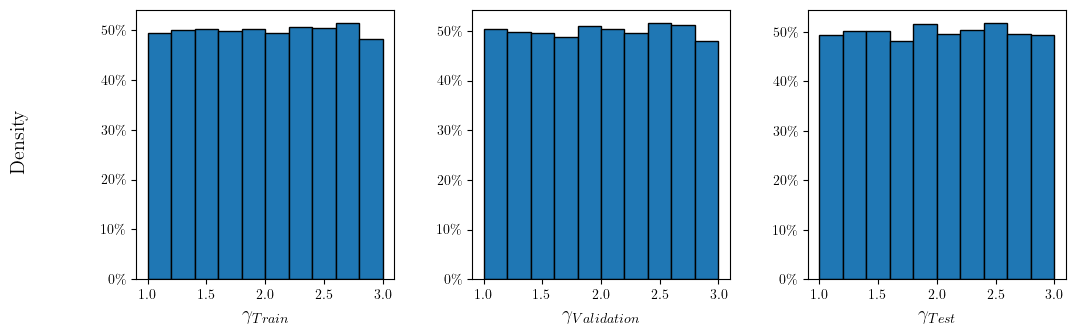

In [66]:
fig, ax = plt.subplots(1, 3, figsize=(12,3.5))
dens = True
if dens:
    fig.supylabel('Density')
else:
    fig.supylabel('Frequency')
# put figure y label closer to the figure
fig.subplots_adjust(wspace=0.3, hspace=0.3)
    
xlabel_list_jkr = ['$\gamma_{Train}$', '$\gamma_{Validation}$', '$\gamma_{Test}$']
for ix, sp in enumerate(ax.flat):
    sp.set_xlabel(xlabel_list_jkr[ix], fontsize=14)
    sp.yaxis.set_major_formatter(PercentFormatter(1))

props = dict(boxstyle='round', facecolor='white', alpha=0.2)
ax[0].hist(train_df_jkr['gamma_jkr'],10, density=dens, ec='black')
ax0 = len(train_df_jkr)
ax[1].hist(valid_df_jkr['gamma_jkr'], 10, density=dens, ec='black')
ax1= len(test_df_jkr)
ax[2].hist(test_df_jkr['gamma_jkr'], 10, density=dens, ec='black')

# savefig as pdf
plt.savefig('jkr_unstrat.pdf', bbox_inches='tight')
# plt.savefig('jkr_strat.pdf', bbox_inches='tight')

In [816]:
'''fig, ax = plt.subplots(2, 3, figsize=(12,8))
dens = True
if dens:
    fig.supylabel('Density')
else:
    fig.supylabel('Frequency')
# put figure y label closer to the figure
fig.subplots_adjust(wspace=0.3, hspace=0.3)
    
xlabel_list_jkr = ['$E_{Train}$', '$E_{Test}$', '$E_{Validation}$',
                  '$\gamma_{Train}$', '$\gamma_{Test}$', '$\gamma_{Validation}$']
for ix, sp in enumerate(ax.flat):
    sp.set_xlabel(xlabel_list_jkr[ix], fontsize=14)
    sp.yaxis.set_major_formatter(PercentFormatter(1))

props = dict(boxstyle='round', facecolor='white', alpha=0.2)
ax[0,0].hist(train_df_jkr['E_jkr'],10, density=dens, ec='black')
ax0 = len(train_df_jkr)
ax[0,0].text(0.395, 0.9, f'Total samples: {ax0}', transform=ax[0,0].transAxes, fontsize=12, bbox=props)
ax[0,1].hist(test_df_jkr['E_jkr'], 10, density=dens, ec='black')
ax1= len(test_df_jkr)
ax[0,1].text(0.395, 0.9, f'Total samples: {ax1}', transform=ax[0,1].transAxes, fontsize=12, bbox=props)
ax[0,2].hist(valid_df_jkr['E_jkr'], 10, density=dens, ec='black')
ax[0,2].text(0.395, 0.9, f'Total samples: {ax1}', transform=ax[0,2].transAxes, fontsize=12, bbox=props)
ax[1,0].hist(train_df_jkr['gamma_jkr'], 10, density=dens, ec='black')
ax[1,1].hist(test_df_jkr['gamma_jkr'], 10, density=dens, ec='black')
ax[1,2].hist(valid_df_jkr['gamma_jkr'], 10, density=dens, ec='black')'''

# savefig as pdf
# plt.savefig('jkr_unstrat.pdf', bbox_inches='tight')
# plt.savefig('jkr_strat.pdf', bbox_inches='tight')

"fig, ax = plt.subplots(2, 3, figsize=(12,8))\ndens = True\nif dens:\n    fig.supylabel('Density')\nelse:\n    fig.supylabel('Frequency')\n# put figure y label closer to the figure\nfig.subplots_adjust(wspace=0.3, hspace=0.3)\n    \nxlabel_list_jkr = ['$E_{Train}$', '$E_{Test}$', '$E_{Validation}$',\n                  '$\\gamma_{Train}$', '$\\gamma_{Test}$', '$\\gamma_{Validation}$']\nfor ix, sp in enumerate(ax.flat):\n    sp.set_xlabel(xlabel_list_jkr[ix], fontsize=14)\n    sp.yaxis.set_major_formatter(PercentFormatter(1))\n\nprops = dict(boxstyle='round', facecolor='white', alpha=0.2)\nax[0,0].hist(train_df_jkr['E_jkr'],10, density=dens, ec='black')\nax0 = len(train_df_jkr)\nax[0,0].text(0.395, 0.9, f'Total samples: {ax0}', transform=ax[0,0].transAxes, fontsize=12, bbox=props)\nax[0,1].hist(test_df_jkr['E_jkr'], 10, density=dens, ec='black')\nax1= len(test_df_jkr)\nax[0,1].text(0.395, 0.9, f'Total samples: {ax1}', transform=ax[0,1].transAxes, fontsize=12, bbox=props)\nax[0,2].hist(va

In [67]:
train_df_jkr.head()

,withdraw,withdraw_contact,f_jkr,f_jkr_contact,E_jkr,gamma_jkr,E_jkr_cat,gamma_jkr_cat
10641,"[150.0, 148.6267470498, 145.01849834681022, 14...","[150.0, 148.6267470498, 145.01849834681022, 14...","[0.7861467009053283, 0.7735922262233006, 0.740...","[0.7861467009053283, 0.7735922262233006, 0.740...",7.207072,1.745811,"(6.952, 7.324]","(1.667, 1.75]"
5877,"[150.0, 145.3070874581916, 144.02050859529103,...","[150.0, 145.3070874581916, 144.02050859529103,...","[0.5252300273245695, 0.49594330244111356, 0.48...","[0.5252300273245695, 0.49594330244111356, 0.48...",5.059555,1.607923,"(4.723, 5.094]","(1.583, 1.667]"
15026,"[150.0, 144.99406063163184, 140.19059296619815...","[150.0, 144.99406063163184, 140.19059296619815...","[0.2552202228041641, 0.23871258533293443, 0.22...","[0.2552202228041641, 0.23871258533293443, 0.22...",2.834129,1.596469,"(2.493, 2.864]","(1.583, 1.667]"
25597,"[150.0, 145.9006887973347, 144.67146993701365,...","[150.0, 145.9006887973347, 144.67146993701365,...","[0.6385715982970324, 0.606298018402557, 0.5967...","[0.6385715982970324, 0.606298018402557, 0.5967...",6.537889,2.737393,"(6.209, 6.581]","(2.667, 2.75]"
30254,"[150.0, 147.43617334690478, 145.23967144786693...","[150.0, 147.43617334690478, 145.23967144786693...","[0.7631831896908213, 0.7408076122494058, 0.721...","[0.7631831896908213, 0.7408076122494058, 0.721...",6.821065,1.406363,"(6.581, 6.952]","(1.333, 1.417]"


In [818]:
'''fig, ax = plt.subplots(2, 3, figsize=(12,8))
dens = True
if dens:
    fig.supylabel('Density')
else:
    fig.supylabel('Frequency')
    
xlabel_list_jkr = ['$E_{train}$', '$E_{test}$', '$E_{valid}$',
                  '$\gamma_{train}$', '$\gamma_{test}$', '$\gamma_{valid}$']
for ix, sp in enumerate(ax.flat):
    sp.set_xlabel(xlabel_list_jkr[ix])

ax[0,0].hist(train_df_jkr['E_jkr_norm'].copy().apply(lambda x: unnormalize(x, e_min, e_max)),10, density=dens)
ax[0,1].hist(test_df_jkr['E_jkr_norm'].copy().apply(lambda x: unnormalize(x, e_min, e_max)), 10, density=dens)
ax[0,2].hist(valid_df_jkr['E_jkr_norm'].copy().apply(lambda x: unnormalize(x, e_min, e_max)), 10, density=dens)
ax[1,0].hist(train_df_jkr['gamma_jkr_norm'].copy().apply(lambda x: unnormalize(x, gamma_min, gamma_max)), 10, density=dens)
ax[1,1].hist(test_df_jkr['gamma_jkr_norm'].copy().apply(lambda x: unnormalize(x, gamma_min, gamma_max)), 10, density=dens)
ax[1,2].hist(valid_df_jkr['gamma_jkr_norm'].copy().apply(lambda x: unnormalize(x, gamma_min, gamma_max)), 10, density=dens)'''



"fig, ax = plt.subplots(2, 3, figsize=(12,8))\ndens = True\nif dens:\n    fig.supylabel('Density')\nelse:\n    fig.supylabel('Frequency')\n    \nxlabel_list_jkr = ['$E_{train}$', '$E_{test}$', '$E_{valid}$',\n                  '$\\gamma_{train}$', '$\\gamma_{test}$', '$\\gamma_{valid}$']\nfor ix, sp in enumerate(ax.flat):\n    sp.set_xlabel(xlabel_list_jkr[ix])\n\nax[0,0].hist(train_df_jkr['E_jkr_norm'].copy().apply(lambda x: unnormalize(x, e_min, e_max)),10, density=dens)\nax[0,1].hist(test_df_jkr['E_jkr_norm'].copy().apply(lambda x: unnormalize(x, e_min, e_max)), 10, density=dens)\nax[0,2].hist(valid_df_jkr['E_jkr_norm'].copy().apply(lambda x: unnormalize(x, e_min, e_max)), 10, density=dens)\nax[1,0].hist(train_df_jkr['gamma_jkr_norm'].copy().apply(lambda x: unnormalize(x, gamma_min, gamma_max)), 10, density=dens)\nax[1,1].hist(test_df_jkr['gamma_jkr_norm'].copy().apply(lambda x: unnormalize(x, gamma_min, gamma_max)), 10, density=dens)\nax[1,2].hist(valid_df_jkr['gamma_jkr_norm'].cop

In [819]:
'''fig, ax = plt.subplots(2, 3, figsize=(12,8))
dens = True
if dens:
    fig.supylabel('Density')
else:
    fig.supylabel('Frequency')
    
xlabel_list_jkr = ['$E_{train}$', '$E_{test}$', '$E_{valid}$',
                  '$\gamma_{train}$', '$\gamma_{test}$', '$\gamma_{valid}$']
for ix, sp in enumerate(ax.flat):
    sp.set_xlabel(xlabel_list_jkr[ix])

ax[0,0].hist(train_df_jkr['E_jkr_norm'],10, density=dens)
ax[0,1].hist(test_df_jkr['E_jkr_norm'], 10, density=dens)
ax[0,2].hist(valid_df_jkr['E_jkr_norm'], 10, density=dens)
ax[1,0].hist(train_df_jkr['gamma_jkr_norm'], 10, density=dens)
ax[1,1].hist(test_df_jkr['gamma_jkr_norm'], 10, density=dens)
ax[1,2].hist(valid_df_jkr['gamma_jkr_norm'], 10, density=dens)'''

"fig, ax = plt.subplots(2, 3, figsize=(12,8))\ndens = True\nif dens:\n    fig.supylabel('Density')\nelse:\n    fig.supylabel('Frequency')\n    \nxlabel_list_jkr = ['$E_{train}$', '$E_{test}$', '$E_{valid}$',\n                  '$\\gamma_{train}$', '$\\gamma_{test}$', '$\\gamma_{valid}$']\nfor ix, sp in enumerate(ax.flat):\n    sp.set_xlabel(xlabel_list_jkr[ix])\n\nax[0,0].hist(train_df_jkr['E_jkr_norm'],10, density=dens)\nax[0,1].hist(test_df_jkr['E_jkr_norm'], 10, density=dens)\nax[0,2].hist(valid_df_jkr['E_jkr_norm'], 10, density=dens)\nax[1,0].hist(train_df_jkr['gamma_jkr_norm'], 10, density=dens)\nax[1,1].hist(test_df_jkr['gamma_jkr_norm'], 10, density=dens)\nax[1,2].hist(valid_df_jkr['gamma_jkr_norm'], 10, density=dens)"

### Defining inputs and labels for train_test_vali dataframes

df -> np.arrays

In [69]:
jkr_df_list = [train_df_jkr, test_df_jkr, valid_df_jkr]
ft_cols = ['withdraw_contact', 'f_jkr_contact']
# lb_cols = ['E_jkr_norm', 'gamma_jkr_norm']
lb_cols = ['E_jkr', 'gamma_jkr']
dataset_jkr_list = []

for _, df in enumerate(jkr_df_list):
    aux_arr_ft = np.array(df[ft_cols])
    dataset_jkr_list.append(aux_arr_ft)
    aux_arr_lb = np.array(df[lb_cols])
    dataset_jkr_list.append(aux_arr_lb)

x_train_jkr, y_train_jkr, x_test_jkr, y_test_jkr, x_valid_jkr, y_valid_jkr = dataset_jkr_list

x_train_jkr.shape, y_train_jkr.shape, x_test_jkr.shape, y_test_jkr.shape, x_valid_jkr.shape, y_valid_jkr.shape

((28000, 2), (28000, 2), (6000, 2), (6000, 2), (6000, 2), (6000, 2))

In [70]:
def tensor_input_shape2(nparray):
    '''
    Input: nparray - numpy array with two dimensions (n_samples, n_features)
    Output: torch_tensor - pytorch tensor with 3 dimensions (n_samples, n_pts, n_features) 
    '''
    n_samples = len(nparray)
    n_pts = len(nparray[0,0])
    torch_tensor = torch.zeros(size=(n_samples, n_pts, 2))
    for i in range(n_samples):
        aux_nparray = np.hstack((np.array(nparray[i,0]).reshape((n_pts,1)), np.array(nparray[i,1]).reshape((n_pts,1))))
        aux_ttensor = torch.from_numpy(aux_nparray).type(torch.float)
        torch_tensor[i,:,:] = aux_ttensor
    return torch_tensor

x_train_t_jkr = tensor_input_shape2(x_train_jkr)
x_valid_t_jkr = tensor_input_shape2(x_valid_jkr)
x_test_t_jkr = tensor_input_shape2(x_test_jkr)
y_train_t_jkr = torch.from_numpy(y_train_jkr).type(torch.float)
y_valid_t_jkr = torch.from_numpy(y_valid_jkr).type(torch.float)
y_test_t_jkr = torch.from_numpy(y_test_jkr).type(torch.float)
#x_train_t2 = torch.from_numpy(x_train).type(torch.float)

x_train_t_jkr.shape, y_train_t_jkr.shape, y_valid_t_jkr.shape, y_test_t_jkr.shape

(torch.Size([28000, 50, 2]),
 torch.Size([28000, 2]),
 torch.Size([6000, 2]),
 torch.Size([6000, 2]))

In [71]:
class JKR_Dataset():
  
  def __init__(self,features,labels):
    self.features = features
    self.labels = labels
 
  def __len__(self):
    return len(self.labels)
   
  def __getitem__(self,idx):
    return self.features[idx],self.labels[idx]

In [72]:
train_data_jkr = JKR_Dataset(x_train_t_jkr, y_train_t_jkr)
test_data_jkr = JKR_Dataset(x_test_t_jkr, y_test_t_jkr)
valid_data_jkr = JKR_Dataset(x_valid_t_jkr, y_valid_t_jkr)

'''# Normalized dataset for training
E_max, E_min = get_max_min(df_jkr['E_jkr'])
gamma_max, gamma_min = get_max_min(df_jkr['gamma_jkr'])
max_tensor = torch.tensor([E_max, gamma_max], dtype=torch.float32)
min_tensor = torch.tensor([E_min, gamma_min], dtype=torch.float32)
y_train_t_jkr_norm = (y_train_t_jkr-min_tensor)/(max_tensor-min_tensor)
train_data_jkr_norm = JKR_Dataset(x_train_t_jkr, y_train_t_jkr_norm)'''


"# Normalized dataset for training\nE_max, E_min = get_max_min(df_jkr['E_jkr'])\ngamma_max, gamma_min = get_max_min(df_jkr['gamma_jkr'])\nmax_tensor = torch.tensor([E_max, gamma_max], dtype=torch.float32)\nmin_tensor = torch.tensor([E_min, gamma_min], dtype=torch.float32)\ny_train_t_jkr_norm = (y_train_t_jkr-min_tensor)/(max_tensor-min_tensor)\ntrain_data_jkr_norm = JKR_Dataset(x_train_t_jkr, y_train_t_jkr_norm)"

In [73]:
################ After changing one of the hyperparameters: ########################
### Re-run the cells where the model class and the model_params dict are defined ###

# HYPERPARAMETERS
LEARNING_RATE_JKR = 0.000299
EPOCHS_JKR = 110
BATCH_SIZE_JKR = 16

# Size of each layer
HIDDEN_UNITS_1_JKR = 128
HIDDEN_UNITS_2_JKR = 32
HIDDEN_UNITS_3_JKR = 128
HIDDEN_UNITS_4_JKR = 16

ARCHITECTURE_JKR = 2

In [74]:
train_loader_jkr=DataLoader(train_data_jkr,batch_size=BATCH_SIZE_JKR,shuffle=True)
test_loader_jkr=DataLoader(test_data_jkr,batch_size=int(test_ratio_jkr*size+1),shuffle=False)
valid_loader_jkr=DataLoader(valid_data_jkr, batch_size=int(valid_ratio_jkr*size+1), shuffle=False)

# train_loader_jkr_norm=DataLoader(train_data_jkr_norm,batch_size=BATCH_SIZE_JKR,shuffle=True)

In [75]:
# Define the linear regression model
nl=3

if nl == 3:
    class Regression_JKR(nn.Module):
        def __init__(self, input_shape, HIDDEN_UNITS_1_JKR, HIDDEN_UNITS_2_JKR, HIDDEN_UNITS_3_JKR, HIDDEN_UNITS_4_JKR):
            super(Regression_JKR, self).__init__()
            input_size = input_shape[0] * input_shape[1]
            self.layers = nn.Sequential(nn.Flatten(),
                                        nn.Linear(input_size, HIDDEN_UNITS_1_JKR),
                                        nn.ReLU(),
                                        nn.Linear(HIDDEN_UNITS_1_JKR,HIDDEN_UNITS_2_JKR),
                                        nn.ReLU(),
                                        nn.Linear(HIDDEN_UNITS_2_JKR,HIDDEN_UNITS_3_JKR),
                                        nn.ReLU(),
                                        nn.Linear(HIDDEN_UNITS_3_JKR, 2))
        def forward(self, x):
            out = self.layers(x)
            return out
elif nl == 4:
    class Regression_JKR(nn.Module):
        def __init__(self, input_shape, HIDDEN_UNITS_1_JKR, HIDDEN_UNITS_2_JKR, HIDDEN_UNITS_3_JKR, HIDDEN_UNITS_4_JKR):
            super(Regression_JKR, self).__init__()
            input_size = input_shape[0] * input_shape[1]
            self.layers = nn.Sequential(nn.Flatten(),
                                        nn.Linear(input_size, HIDDEN_UNITS_1_JKR),
                                        nn.ReLU(),
                                        nn.Linear(HIDDEN_UNITS_1_JKR,HIDDEN_UNITS_2_JKR),
                                        nn.ReLU(),
                                        nn.Linear(HIDDEN_UNITS_2_JKR,HIDDEN_UNITS_3_JKR),
                                        nn.ReLU(),
                                        nn.Linear(HIDDEN_UNITS_3_JKR,HIDDEN_UNITS_4_JKR),
                                        nn.ReLU(),
                                        nn.Linear(HIDDEN_UNITS_4_JKR, 2))
        def forward(self, x):
            out = self.layers(x)
            return out

# Define input shape
input_shape_jkr = x_train_t_jkr.shape[1:]

# Instantiate the model
torch.manual_seed(42)
model_jkr = Regression_JKR(input_shape_jkr, HIDDEN_UNITS_1_JKR, HIDDEN_UNITS_2_JKR, HIDDEN_UNITS_3_JKR, HIDDEN_UNITS_4_JKR)


# Experimentar Huber Loss, log-cosh e quantile loss !!!!!!!!!!
# Define the loss function and optimizer
loss_fn_jkr = nn.MSELoss(reduction='none')
# loss_fn_jkr = nn.HuberLoss(reduction='none')

optimizer_jkr = torch.optim.Adam(model_jkr.parameters(),
                                lr=LEARNING_RATE_JKR)

In [827]:
# Define the linear regression model
'''class Regression_JKR_norm(nn.Module):
    def __init__(self, input_shape, HIDDEN_UNITS_1_JKR, HIDDEN_UNITS_2_JKR, HIDDEN_UNITS_3_JKR):
        super(Regression_JKR_norm, self).__init__()
        input_size = input_shape[0] * input_shape[1]
        self.layers = nn.Sequential(nn.Flatten(),
                                    nn.Linear(input_size, HIDDEN_UNITS_1_JKR),
                                    nn.LeakyReLU(),
                                    nn.Linear(HIDDEN_UNITS_1_JKR,HIDDEN_UNITS_2_JKR),
                                    nn.LeakyReLU(),
                                    nn.Linear(HIDDEN_UNITS_2_JKR,HIDDEN_UNITS_3_JKR),
                                    nn.LeakyReLU(),
                                    nn.Linear(HIDDEN_UNITS_3_JKR, 2),
                                    nn.BatchNorm1d(2))
    def forward(self, x):
        out = self.layers(x)
        return out
# Define input shape
input_shape_jkr = x_train_t_jkr.shape[1:]

# Instantiate the model
torch.manual_seed(42)
model_jkr_norm = Regression_JKR_norm(input_shape_jkr, HIDDEN_UNITS_1_JKR, HIDDEN_UNITS_2_JKR, HIDDEN_UNITS_3_JKR)

# Define the loss function and optimizer
loss_fn_jkr_norm = nn.MSELoss(reduction='none')
# loss_fn_jkr_norm = nn.MSELoss()
# loss_fn_jkr_norm = nn.HuberLoss(reduction='none')

optimizer_jkr_norm = torch.optim.Adam(model_jkr_norm.parameters(),
                                lr=LEARNING_RATE_JKR)'''

"class Regression_JKR_norm(nn.Module):\n    def __init__(self, input_shape, HIDDEN_UNITS_1_JKR, HIDDEN_UNITS_2_JKR, HIDDEN_UNITS_3_JKR):\n        super(Regression_JKR_norm, self).__init__()\n        input_size = input_shape[0] * input_shape[1]\n        self.layers = nn.Sequential(nn.Flatten(),\n                                    nn.Linear(input_size, HIDDEN_UNITS_1_JKR),\n                                    nn.LeakyReLU(),\n                                    nn.Linear(HIDDEN_UNITS_1_JKR,HIDDEN_UNITS_2_JKR),\n                                    nn.LeakyReLU(),\n                                    nn.Linear(HIDDEN_UNITS_2_JKR,HIDDEN_UNITS_3_JKR),\n                                    nn.LeakyReLU(),\n                                    nn.Linear(HIDDEN_UNITS_3_JKR, 2),\n                                    nn.BatchNorm1d(2))\n    def forward(self, x):\n        out = self.layers(x)\n        return out\n# Define input shape\ninput_shape_jkr = x_train_t_jkr.shape[1:]\n\n# Instantiate the mo

In [828]:
# Custom loss functions
class NMSELoss(nn.Module):
    def __init__(self):
        super(NMSELoss, self).__init__()
        # self.mse = nn.MSELoss()
        self.mse = nn.MSELoss(reduction='none')
    def forward(self, input, target):
        # Compute the mean squared error (MSE)
        mse = self.mse(input, target)
        # Compute the normalization factor
        # norm_factor = torch.mean(torch.square(target))
        norm_factor = torch.square(target)
        # norm_factor = target * input

        # Compute the normalized mean squared error (NMSE)
        nmse = (mse / norm_factor)
        # nmse = (mse / norm_factor).mean(dim=0)

        return nmse
    
class MAPELoss(nn.Module):
    def __init__(self):
        super(MAPELoss, self).__init__()
        self.mape = nn.L1Loss(reduction='none')
    
    def forward(self, input, target):
        mape = self.mape(input, target)
        norm_factor = torch.abs(target)
        mape = (mape / norm_factor)
        return mape

# Class for the normalized root mean squared error (NRMSE) loss
class NRMSELoss(nn.Module):
    def __init__(self):
        super(NRMSELoss, self).__init__()
        # self.mse = nn.MSELoss()
        self.mse = nn.MSELoss(reduction='none')
    def forward(self, input, target):
        # Compute the mean squared error (MSE)
        mse = self.mse(input, target)
        # Compute the normalization factor
        norm_factor = torch.mean(torch.square(target))
        # norm_factor = torch.square(target)
        # norm_factor = target * input
        # Compute the normalized mean squared error (NMSE)
        nmse = (mse / norm_factor)
        # Compute the normalized root mean squared error (NRMSE)
        nrmse = torch.sqrt(nmse)

        return nrmse
    
# loss_fn_jkr = MAPELoss()
# loss_fn_jkr = NRMSELoss()

In [76]:
'''summary(model = model_jkr,
        input_size=(16,50,2),
        col_names = ["input_size", "output_size", "num_params"],
        col_width=20,
        row_settings=["var_names"])'''



Layer (type (var_name))                  Input Shape          Output Shape         Param #
Regression_JKR (Regression_JKR)          [16, 50, 2]          [16, 2]              --
├─Sequential (layers)                    [16, 50, 2]          [16, 2]              --
│    └─Flatten (0)                       [16, 50, 2]          [16, 100]            --
│    └─Linear (1)                        [16, 100]            [16, 128]            12,928
│    └─ReLU (2)                          [16, 128]            [16, 128]            --
│    └─Linear (3)                        [16, 128]            [16, 32]             4,128
│    └─ReLU (4)                          [16, 32]             [16, 32]             --
│    └─Linear (5)                        [16, 32]             [16, 128]            4,224
│    └─ReLU (6)                          [16, 128]            [16, 128]            --
│    └─Linear (7)                        [16, 128]            [16, 2]              258
Total params: 21,538
Trainable params:

In [829]:
model_params_jkr = {'Epochs': EPOCHS_JKR, 
                'Learning Rate': LEARNING_RATE_JKR,
                'Batch Size': BATCH_SIZE_JKR,
                'Number of Hidden layers': nl,
                'Type of layers': nn.Linear,
                'Activation function': nn.LeakyReLU(),
                'Architecture': ARCHITECTURE_JKR,
                'Hidden Units 1': HIDDEN_UNITS_1_JKR,
                'Hidden Units 2': HIDDEN_UNITS_2_JKR,
                'Hidden Units 3': HIDDEN_UNITS_3_JKR,
                'Hidden Units 4': HIDDEN_UNITS_4_JKR,
                'Input shape': list(input_shape_jkr),
                'Loss function': loss_fn_jkr,
                'Optimizer': optimizer_jkr}
model_params_jkr

{'Epochs': 120,
 'Learning Rate': 0.0008003,
 'Batch Size': 16,
 'Number of Hidden layers': 3,
 'Type of layers': torch.nn.modules.linear.Linear,
 'Activation function': LeakyReLU(negative_slope=0.01),
 'Architecture': 2,
 'Hidden Units 1': 128,
 'Hidden Units 2': 128,
 'Hidden Units 3': 64,
 'Hidden Units 4': 16,
 'Input shape': [50, 2],
 'Loss function': MSELoss(),
 'Optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.0008003
     maximize: False
     weight_decay: 0
 )}

In [830]:
def train_one_epoch_jkr(epoch_index, train_loader): # (epoch_index, tb_writer)
    # running_loss = 0.
    # last_loss = 0.
    loss_list = []
    error_E_list = []
    error_gamma_list = []
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        optimizer_jkr.zero_grad()
        predicts = model_jkr(inputs)
        # print(predicts)
        # Compute the loss and its gradients
        loss = loss_fn_jkr(predicts, labels).mean(dim=0)
        '''max, _ = loss_fn_jkr(predicts, labels).max(0)
        loss = (loss_fn_jkr(predicts, labels)/max).mean()'''
        '''loss1, loss2 = loss_fn_jkr(predicts[:,0], labels[:,0]), loss_fn_jkr(predicts[:,1], labels[:,1])
        loss = loss1 * loss2'''
        error_E, _ = error_fn(predicts[:,0].unsqueeze(dim=1), labels[:,0].unsqueeze(dim=1))
        error_gamma, _ = error_fn(predicts[:,1].unsqueeze(dim=1), labels[:,1].unsqueeze(dim=1))
        loss.backward(gradient=torch.Tensor([1., 1.]))
        # Adjust learning weights
        optimizer_jkr.step()
        # Gather data and report
        loss_list.append(loss.detach().numpy())
        error_E_list.append(error_E)
        error_gamma_list.append(error_gamma)
        # running_loss += loss.item()  # .item() converts tensor to number
        # print(i, loss.item())
    return loss_list, error_E_list, error_gamma_list

In [831]:
def train_model_JKR(EPOCHS: int,
                      model_jkr,
                      train_loader,
                      valid_loader,
                      loss_fn_jkr,
                      optimizer_jkr,
                      x_test_t, y_test_t,
                      dataset_list: list,
                      model_params_jkr: dict,
                      ):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    # Set new directory for new model
    initial_wd = os.getcwd()
    create_model_dir(timestamp, contact_model='jkr')

    best_vloss = 1e15
    cols = ['Epoch', 'Train Loss', 'Mean Train Loss', 'Mean Val Loss', 
            'E - Train loss', 'E - Val loss','E - Train Error (%)', 'E - Mean Train Error (%)', 'E - Mean Val Error (%)', 
            'gamma - Train loss', 'gamma - Val loss','gamma - Train Error (%)', 'gamma - Mean Train Error (%)', 'gamma - Mean Val Error (%)']
    row = []
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1} of {EPOCHS}')
        # Make sure gradient tracking is on, and do a pass over the data
        model_jkr.train(True)
        loss_list, error_E_list, error_gamma_list = train_one_epoch_jkr(epoch, train_loader) # loss_list is a np array
        loss_E = np.array(loss_list)[:,0].mean()
        loss_gamma = np.array(loss_list)[:,1].mean()
        # We don't need gradients on to do reporting
        model_jkr.train(False)
        running_vloss, running_verror_E, running_verror_gamma = 0.0, 0.0, 0.0
        running_vloss_E, running_vloss_gamma = 0.0, 0.0
        verror_E_list, verror_gamma_list, fts_list, labels_list = [], [], [], []
        # Validation cycle
        for i, vdata in enumerate(valid_loader):
            vinputs, vlabels = vdata
            fts_list.append(vinputs)
            labels_list.append(vlabels)
            voutputs = model_jkr(vinputs)
            vloss = loss_fn_jkr(voutputs, vlabels).mean(dim=0)
            vloss_E = vloss[0].item()
            vloss_gamma = vloss[1].item()
            '''max, _ = loss_fn_jkr(voutputs, vlabels).max(0)
            vloss = (loss_fn_jkr(voutputs, vlabels)/max).mean()'''
            '''vloss1, vloss2 = loss_fn_jkr(voutputs[:,0], vlabels[:,0]), loss_fn_jkr(voutputs[:,1], vlabels[:,1])
            vloss = vloss1 * vloss2'''        
            verror_E, verror_E_aux_list = error_fn(voutputs[:,0].unsqueeze(dim=1), vlabels[:,0].unsqueeze(dim=1))
            verror_gamma, verror_gamma_aux_list = error_fn(voutputs[:,1].unsqueeze(dim=1), vlabels[:,1].unsqueeze(dim=1))
            running_vloss += vloss.detach().mean().item()
            running_vloss_E += vloss_E
            running_vloss_gamma += vloss_gamma
            running_verror_E += verror_E
            running_verror_gamma += verror_gamma
            verror_E_list += verror_E_aux_list
            verror_gamma_list += verror_gamma_aux_list
        
        avg_vloss = running_vloss / (i + 1)
        avg_vloss_E = running_vloss_E / (i + 1)
        avg_vloss_gamma = running_vloss_gamma / (i + 1)
        verror_list = [verror_E_list, verror_gamma_list]
        avg_verror_E = running_verror_E / (i + 1)
        avg_verror_gamma = running_verror_gamma / (i + 1)
        row.append(dict(zip(cols, 
                            [epoch+1, loss_list, np.array(loss_list).mean(), avg_vloss, 
                            loss_E, avg_vloss_E, error_E_list, np.array(error_E_list).mean(), avg_verror_E,
                            loss_gamma, avg_vloss_gamma, error_gamma_list, np.array(error_gamma_list).mean(), avg_verror_gamma])))
        # print(avg_verror_E, avg_verror_gamma, avg_vloss, loss_E)
        # print(error_E_list, error_gamma_list)
        # Track best performance
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'model_state_dict_{}_{}.pt'.format(timestamp, epoch+1)
            verror_E_list_best = verror_E_list
            verror_gamma_list_best = verror_gamma_list
            fts_list_best = fts_list
            labels_list_best = labels_list
    torch.save(model_jkr.state_dict(), model_path)
    model_params_jkr['Model Path'] = model_path
    df = pd.DataFrame(row)
    df.to_csv('loss_error.csv', index=False)
    plot_loss_curve2(df['Epoch'].values.tolist(), df['Mean Train Loss'].values.tolist(), df['Mean Val Loss'].values.tolist(), loss=True, E=False, gamma=False)
    plot_loss_curve2(df['Epoch'].values.tolist(), df['E - Train loss'].values.tolist(), df['E - Val loss'].values.tolist(), loss=True, E=True, gamma=False)
    plot_loss_curve2(df['Epoch'].values.tolist(), df['gamma - Train loss'].values.tolist(), df['gamma - Val loss'].values.tolist(), loss=True, E=False, gamma=True)
    plot_loss_curve2(df['Epoch'].values.tolist(), df['E - Mean Train Error (%)'].values.tolist(), df['E - Mean Val Error (%)'].values.tolist(), loss=False, E=True, gamma=False)
    plot_loss_curve2(df['Epoch'].values.tolist(), df['gamma - Mean Train Error (%)'].values.tolist(), df['gamma - Mean Val Error (%)'].values.tolist(), loss=False, E=False, gamma=True)
    plot_bad_curves2(verror_E_list_best, verror_gamma_list_best, fts_list_best, labels_list_best, test=False)
    plot_error_hist2(verror_E_list_best, test=False, E=True)
    plot_error_hist2(verror_gamma_list_best, test=False, E=False)
    with open('model_params.csv', 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = model_params_jkr.keys())
        writer.writeheader()
        writer.writerow(model_params_jkr)
    print(x_test_t.shape, y_test_t.shape)
    torch.save(x_test_t, 'x_test_t.pt')
    torch.save(y_test_t, 'y_test_t.pt')
    data_as_pkl(dataset_list)
    os.chdir(initial_wd)

In [832]:
os.chdir('c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese\\contact-surface')

Epoch 1 of 120


Epoch 2 of 120
Epoch 3 of 120
Epoch 4 of 120
Epoch 5 of 120
Epoch 6 of 120
Epoch 7 of 120
Epoch 8 of 120
Epoch 9 of 120
Epoch 10 of 120
Epoch 11 of 120
Epoch 12 of 120
Epoch 13 of 120
Epoch 14 of 120
Epoch 15 of 120
Epoch 16 of 120
Epoch 17 of 120
Epoch 18 of 120
Epoch 19 of 120
Epoch 20 of 120
Epoch 21 of 120
Epoch 22 of 120
Epoch 23 of 120
Epoch 24 of 120
Epoch 25 of 120
Epoch 26 of 120
Epoch 27 of 120
Epoch 28 of 120
Epoch 29 of 120
Epoch 30 of 120
Epoch 31 of 120
Epoch 32 of 120
Epoch 33 of 120
Epoch 34 of 120
Epoch 35 of 120
Epoch 36 of 120
Epoch 37 of 120
Epoch 38 of 120
Epoch 39 of 120
Epoch 40 of 120
Epoch 41 of 120
Epoch 42 of 120
Epoch 43 of 120
Epoch 44 of 120
Epoch 45 of 120
Epoch 46 of 120
Epoch 47 of 120
Epoch 48 of 120
Epoch 49 of 120
Epoch 50 of 120
Epoch 51 of 120
Epoch 52 of 120
Epoch 53 of 120
Epoch 54 of 120
Epoch 55 of 120
Epoch 56 of 120
Epoch 57 of 120
Epoch 58 of 120
Epoch 59 of 120
Epoch 60 of 120
Epoch 61 of 120
Epoch 62 of 120
Epoch 63 of 120
Epoch 64 of 120


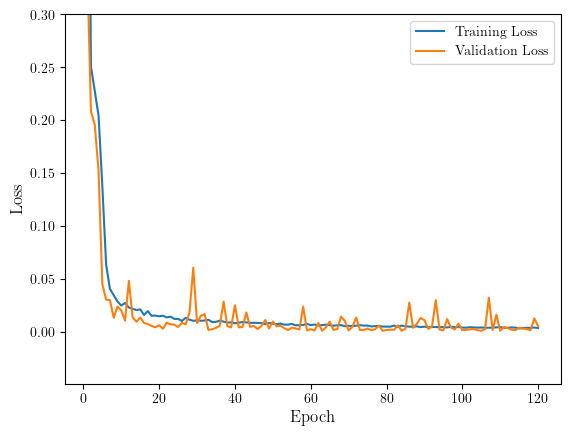

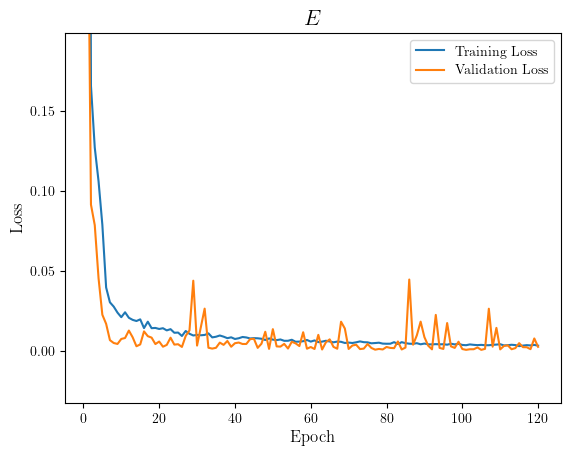

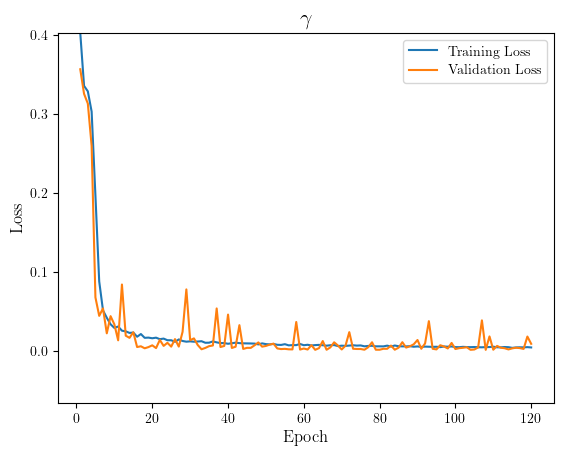

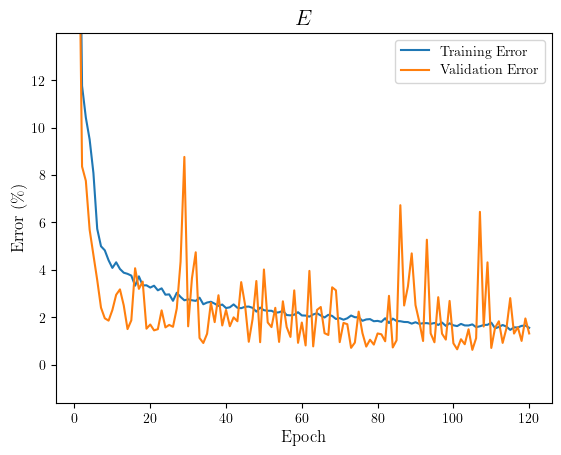

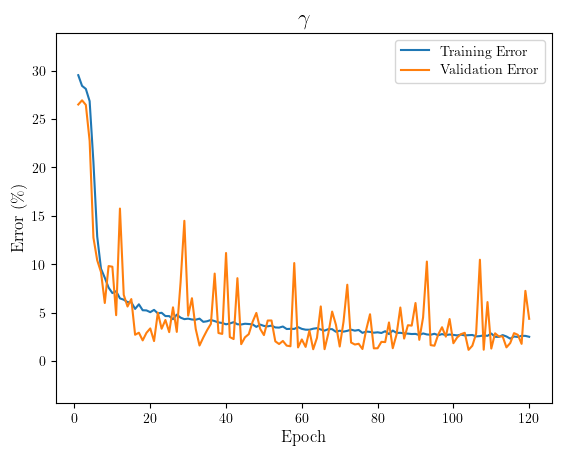

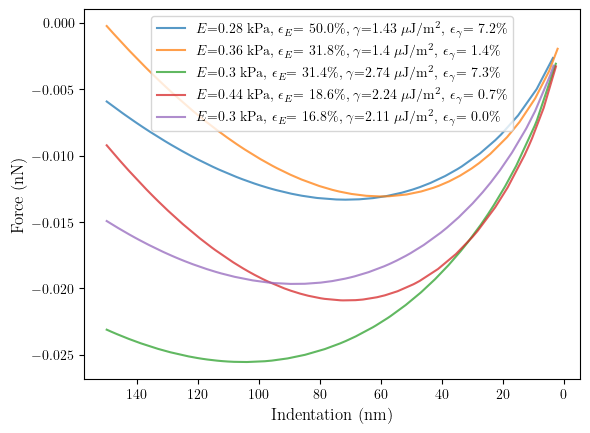

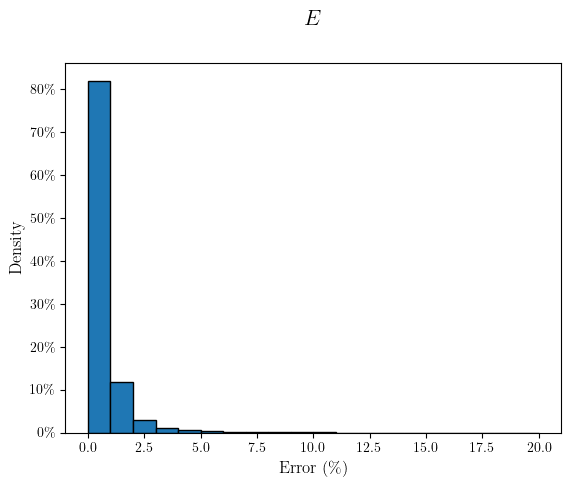

<Figure size 640x480 with 0 Axes>

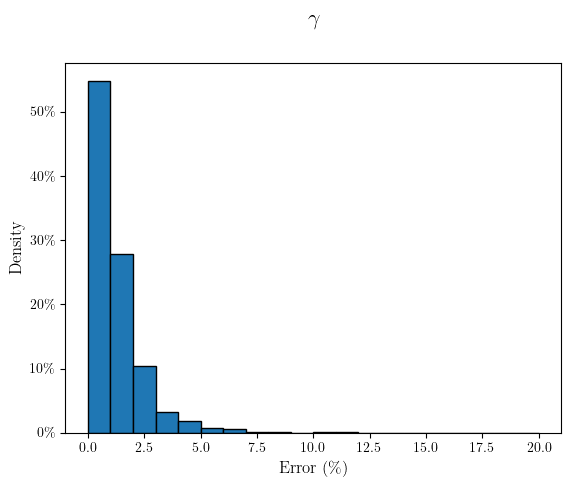

<Figure size 640x480 with 0 Axes>

torch.Size([6000, 50, 2]) torch.Size([6000, 2])


In [833]:
train_model_JKR(EPOCHS_JKR, model_jkr, train_loader_jkr, valid_loader_jkr, loss_fn_jkr, optimizer_jkr, x_test_t_jkr, y_test_t_jkr, dataset_jkr_list, model_params_jkr)

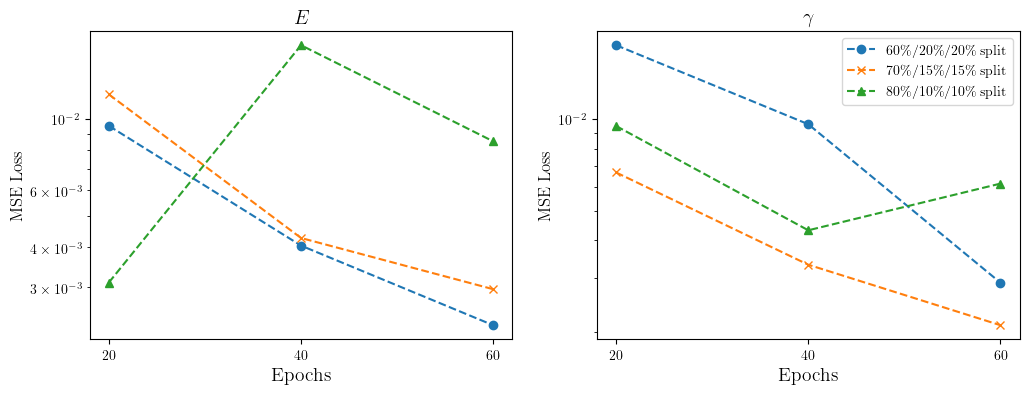

In [834]:
# Figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Boxplots overlayed
s60_E = [0.009533, 0.004033, 0.002277]
s70_E = [0.011947, 0.00426, 0.002949]
s80_E = [0.003094, 0.01701, 0.00853]

s60_gamma = [0.01753, 0.00963, 0.002897]
s70_gamma = [0.00668, 0.00332, 0.002099]
s80_gamma = [0.0095, 0.00431, 0.00614]

x = [20,40,60]

# Plot for E
# ax1.boxplot([s60_E, s70_E, s80_E], labels=["$60\%/20\%/20\%$ split", "$70\%/15\%/15\%$ split", "$80\%/10\%/10\%$ split"])

#plt.plot(x, s60, label="$60\%/20\%/20\%$ split", marker='o', linestyle='--')
#plt.plot(x, s70, label="$70\%/15\%/15\%$ split", marker='x', linestyle='--')
# plt.plot(x, s80, label="$80\%/10\%/10\%$ split", marker='^', linestyle='--')

ax1.set_title('$E$')
ax1.set_ylabel('MSE Loss')
ax1.set_xlabel('Epochs', fontsize=14)
ax1.plot(x, s60_E, label="$60\%/20\%/20\%$ split", marker='o', linestyle='--')
ax1.plot(x, s70_E, label="$70\%/15\%/15\%$ split", marker='x', linestyle='--')
ax1.plot(x, s80_E, label="$80\%/10\%/10\%$ split", marker='^', linestyle='--')
# ax1.legend()
# Hide values in y axis except for the ones specified

ax1.set_xticks(x)
ax1.set_yscale('log')
ax1.set_yticks([10**-2])
ax2.set_title('$\gamma$')
ax2.set_ylabel('MSE Loss')
ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_xticks(x)
ax2.plot(x, s60_gamma, label="$60\%/20\%/20\%$ split", marker='o', linestyle='--')
ax2.plot(x, s70_gamma, label="$70\%/15\%/15\%$ split", marker='x', linestyle='--')
ax2.plot(x, s80_gamma, label="$80\%/10\%/10\%$ split", marker='^', linestyle='--')
ax2.legend()
ax2.set_yscale('log')
# y axis in log scale
# y label
# plt.ylabel('MSE Loss', fontsize=14)
# x label
# plt.xlabel('Epochs', fontsize=14)
# x ticks only for 20, 40 and 60
# save plot as pdf
plt.savefig('loss_split_epoch_JKR.pdf', bbox_inches='tight')

In [835]:
loss_epoch, error_E_epoch, error_gamma_epoch = [], [], []
for i in range(0):
    loss_list = []
    error_E_list = []
    error_gamma_list = []
    for i, data in enumerate(train_loader_jkr):
        # Every data instance is an input + label pair
        inputs, labels = data
        optimizer_jkr.zero_grad()
        predicts = model_jkr(inputs)
        # Compute the loss and its gradients
        loss = loss_fn_jkr(predicts, labels).mean(dim=0)
        # loss = criterion_jkr(predicts, labels)
        # For MAE:
        '''loss = loss_fn_jkr(predicts, labels)
        loss = loss/labels
        loss = loss.mean(dim=0)
        if i == 0:
            max_loss, _ = loss_fn_jkr(predicts, labels).max(0)
            max_loss = max_loss.detach()
        loss = (loss_fn_jkr(predicts, labels)/max_loss).mean()
        loss1, loss2 = loss_fn_jkr(predicts[:,0], labels[:,0]), loss_fn_jkr(predicts[:,1], labels[:,1])
        loss = loss1 + 100*loss2
        loss1, loss2 = loss_fn_jkr(predicts[:,0], labels[:,0]), loss_fn_jkr(predicts[:,1], labels[:,1])
        loss = loss1 * loss2'''
        # real_predicts = unnormalize(predicts, torch.tensor([e_min, gamma_min]), torch.tensor([e_max, gamma_max]))
        # real_labels = unnormalize(labels, torch.tensor([e_min, gamma_min]), torch.tensor([e_max, gamma_max]))
        error_E, _ = error_fn(predicts[:,0].unsqueeze(dim=1), labels[:,0].unsqueeze(dim=1))
        error_gamma, _ = error_fn(predicts[:,1].unsqueeze(dim=1), labels[:,1].unsqueeze(dim=1))
        loss.backward(gradient=torch.tensor([1., 1.]))
        # loss.backward()
        # Adjust learning weights
        optimizer_jkr.step()
        # Gather data and report
        # loss_list.append(loss.item())
        loss_list.append(loss)
        error_E_list.append(error_E)
        error_gamma_list.append(error_gamma)
    loss_epoch.append(sum(loss_list)/len(loss_list))
    error_E_epoch.append(sum(error_E_list)/len(error_E_list))
    error_gamma_epoch.append(sum(error_gamma_list)/len(error_gamma_list))


In [836]:
loss_epoch, error_E_epoch, error_gamma_epoch = [], [], []
E_max, E_min = get_max_min(df_jkr['E_jkr'])
gamma_max, gamma_min = get_max_min(df_jkr['gamma_jkr'])
max_tensor = torch.Tensor([E_max, gamma_max])
min_tensor = torch.Tensor([E_min, gamma_min])
for i in range(0):
    loss_list = []
    error_E_list = []
    error_gamma_list = []
    for i, data in enumerate(train_loader_jkr):
        # Every data instance is an input + label pair
        inputs, labels = data
        optimizer_jkr.zero_grad()
        predicts = model_jkr(inputs)
        # Compute the loss and its gradients
        loss = loss_fn_jkr(predicts, labels).mean(dim=0)
        # loss = criterion_jkr(predicts, labels)
        # For MAE:
        '''loss = loss_fn_jkr(predicts, labels)
        loss = loss/labels
        loss = loss.mean(dim=0)
        if i == 0:
            max_loss, _ = loss_fn_jkr(predicts, labels).max(0)
            max_loss = max_loss.detach()
        loss = (loss_fn_jkr(predicts, labels)/max_loss).mean()
        loss1, loss2 = loss_fn_jkr(predicts[:,0], labels[:,0]), loss_fn_jkr(predicts[:,1], labels[:,1])
        loss = loss1 + 100*loss2
        loss1, loss2 = loss_fn_jkr(predicts[:,0], labels[:,0]), loss_fn_jkr(predicts[:,1], labels[:,1])
        loss = loss1 * loss2'''
        error_E, _ = error_fn(predicts[:,0].unsqueeze(dim=1), labels[:,0].unsqueeze(dim=1))
        error_gamma, _ = error_fn(predicts[:,1].unsqueeze(dim=1), labels[:,1].unsqueeze(dim=1))
        loss.backward(gradient=torch.tensor([1., 1.]))
        # loss.backward()
        # Adjust learning weights
        optimizer_jkr.step()
        # Gather data and report
        # loss_list.append(loss.item())
        loss_list.append(loss)
        error_E_list.append(error_E)
        error_gamma_list.append(error_gamma)
    loss_epoch.append(sum(loss_list)/len(loss_list))
    error_E_epoch.append(sum(error_E_list)/len(error_E_list))
    error_gamma_epoch.append(sum(error_gamma_list)/len(error_gamma_list))

In [837]:
'''loss_epoch, error_E_epoch, error_gamma_epoch = [], [], []
for i in range(1000):
    loss_list = []
    error_E_list = []
    error_gamma_list = []
    for i, data in enumerate(train_loader_jkr):
        # Every data instance is an input + label pair
        inputs, labels = data
        optimizer_jkr_norm.zero_grad()
        predicts = model_jkr_norm(inputs)
        # Compute the loss and its gradients
        loss = loss_fn_jkr_norm(predicts, labels).mean(dim=0)
        # loss = abs(loss-labels)/labels
        # loss = loss.mean(dim=0)
        error_E, _ = error_fn(predicts[:,0].unsqueeze(dim=1), labels[:,0].unsqueeze(dim=1))
        error_gamma, _ = error_fn(predicts[:,1].unsqueeze(dim=1), labels[:,1].unsqueeze(dim=1))
        loss.backward(gradient=torch.tensor([1., 1.]))
        # loss.backward()
        # Adjust learning weights
        optimizer_jkr_norm.step()
        # Gather data and report
        # loss_list.append(loss.item())
        loss_list.append(loss)
        error_E_list.append(error_E)
        error_gamma_list.append(error_gamma)
    loss_epoch.append(sum(loss_list)/len(loss_list))
    error_E_epoch.append(sum(error_E_list)/len(error_E_list))
    error_gamma_epoch.append(sum(error_gamma_list)/len(error_gamma_list))'''

'loss_epoch, error_E_epoch, error_gamma_epoch = [], [], []\nfor i in range(1000):\n    loss_list = []\n    error_E_list = []\n    error_gamma_list = []\n    for i, data in enumerate(train_loader_jkr):\n        # Every data instance is an input + label pair\n        inputs, labels = data\n        optimizer_jkr_norm.zero_grad()\n        predicts = model_jkr_norm(inputs)\n        # Compute the loss and its gradients\n        loss = loss_fn_jkr_norm(predicts, labels).mean(dim=0)\n        # loss = abs(loss-labels)/labels\n        # loss = loss.mean(dim=0)\n        error_E, _ = error_fn(predicts[:,0].unsqueeze(dim=1), labels[:,0].unsqueeze(dim=1))\n        error_gamma, _ = error_fn(predicts[:,1].unsqueeze(dim=1), labels[:,1].unsqueeze(dim=1))\n        loss.backward(gradient=torch.tensor([1., 1.]))\n        # loss.backward()\n        # Adjust learning weights\n        optimizer_jkr_norm.step()\n        # Gather data and report\n        # loss_list.append(loss.item())\n        loss_list.append

In [838]:
# predicts[:8, :], labels[:8, :]

In [839]:
# labels[:,0].min(), labels[:,0].max(), labels[:,0].mean(), labels[:,1].min(), labels[:,1].max(), labels[:,1].mean()

In [840]:
# loss_epoch[0], loss_epoch[-1], error_E_epoch[0], error_E_epoch[-1], min(error_E_epoch), error_gamma_epoch[0], error_gamma_epoch[-1], min(error_gamma_epoch)

In [841]:
# loss_epoch[0], loss_epoch[-1]

In [842]:
'''fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Error (\%)')
ax1.set_title('E')
ax1.plot(error_E_epoch)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Error (\%)')
ax2.set_title('$\gamma$')
ax2.plot(error_gamma_epoch)'''


"fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))\nax1.set_xlabel('Epoch')\nax1.set_ylabel('Error (\\%)')\nax1.set_title('E')\nax1.plot(error_E_epoch)\nax2.set_xlabel('Epoch')\nax2.set_ylabel('Error (\\%)')\nax2.set_title('$\\gamma$')\nax2.plot(error_gamma_epoch)"

In [843]:
'''plt.plot(error_gamma_epoch)
plt.title('$\gamma$ - Error vs epoch')'''

"plt.plot(error_gamma_epoch)\nplt.title('$\\gamma$ - Error vs epoch')"

In [844]:
'''a = torch.tensor([1., 2., 3.], requires_grad=True)
# return only the tensor without the gradient in numpy
a = a.detach().numpy()'''





'a = torch.tensor([1., 2., 3.], requires_grad=True)\n# return only the tensor without the gradient in numpy\na = a.detach().numpy()'